## <font color = #990775> INSURANCE CROSS SELL</font>

## <font color=#990775>0 - IMPORTS</font>

In [89]:
import numpy               as np
import pandas              as pd
import seaborn             as sns
import sweetviz            as sv
import scikitplot          as skplt
import pandas.io.sql       as sqlio
import plotly.express      as px
import matplotlib.pyplot   as plt

import math
import pickle
import psycopg2
import datetime
import inflection

from numpy                 import int64
from scipy                 import stats                  as ss
from sklearn               import metrics                as mt
from sklearn               import ensemble               as en
from sklearn               import neighbors              as nh
from sklearn               import linear_model           as lm
from sklearn               import preprocessing          as pp
from sklearn               import model_selection        as ms

# from skopt                 import forest_minimize
from boruta                import BorutaPy
from tabulate              import tabulate
from lightgbm              import LGBMClassifier
from sklearn.metrics       import roc_auc_score
from IPython.display       import Image
from sklearn.ensemble      import RandomForestClassifier
from IPython.core.display  import HTML


from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### <font color = #990775>Helper Functions</font>

In [73]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def create_connection_database(host_name, port_num, database_name, user_name, password_name):
    connection = None
    connection = psycopg2.connect(
                        host = host_name,
                        port = port_num,
                        database = database_name,
                        user = user_name,
                        password = password_name)
    return connection


def precision_at_k(data, yhat_proba, perc):
    
    k = int(np.floor(len(data)*perc))
    data['score'] = yhat_proba[:, 1].tolist()
    data = data.sort_values('score', ascending=False)
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k (data, yhat_proba, perc):
    
    k = int(np.floor(len(data)*perc))
    data['score'] = yhat_proba[:, 1].tolist()
    data = data.sort_values('score', ascending=False)
    data = data.reset_index(drop=True)
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k, 'recall_at_k']


def model_performance (model_name, model): 

    # model training
    m = model.fit(x_train, y_train)

    # model prediction - predicts/calculates the probability of having "1" as response on validation data
    yhat_model = model.predict_proba(x_val)

    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
    # Cumulative Gain Curve
    skplt.metrics.plot_cumulative_gain(y_val, yhat_model, ax=axs[0], title="Cumulative Gain " + model_name);
    # Lift Curve
    skplt.metrics.plot_lift_curve(y_val, yhat_model, ax=axs[1], title="Lift Curve " + model_name);

    # copy data
    df_per = x_validation.copy()
    df_per['response'] = y_validation.copy()

    # propensity score
    df_per['score'] = yhat_model[:, 1].tolist()

    # sort clients by propensity score
    df_per = df_per.sort_values('score', ascending=False)

    # compute Precision at K
    precision_at_20 = precision_at_k(df_per, yhat_model, 0.2)
    precision_at_40 = precision_at_k(df_per, yhat_model, 0.4)

    #compute Recall at K
    recall_at_20 = recall_at_k(df_per, yhat_model, 0.2)
    recall_at_40 = recall_at_k(df_per, yhat_model, 0.4)
    
    print(model_name)
    print('Precision at k=20%: {}'.format(precision_at_20))
    print('Recall    at k=20%: {}'.format(recall_at_20))
    print('Precision at k=40%: {}'.format(precision_at_40))
    print('Recall    at k=40%: {}'.format(recall_at_40))


def cross_validation(models, models_performance, num_folds, x_train, y_train):

    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    models_performance_cv = models_performance.copy()

    precision_list = []
    recall_list = []
    f1_list = []
    roc_list = []
    
    for key, value in models.items():
        
        modelName = key
        model = value

        i=1
        for train_cv, val_cv in kfold.split(x_train, y_train):

            x_train_fold = x_train.iloc[train_cv]
            y_train_fold = y_train.iloc[train_cv]

            x_val_fold = x_train.iloc[val_cv]
            y_val_fold = y_train.iloc[val_cv]

            model_fit = model.fit(x_train_fold, y_train_fold)

            yhat_model = model_fit.predict_proba(x_val_fold)

            x_val_fold['response'] = y_val_fold
            precision = round(precision_at_k(x_val_fold, yhat_model, 0.20), 3)
            recall = round(recall_at_k(x_val_fold, yhat_model, 0.20), 3)
            f1 = round(2*(precision*recall)/(precision+recall), 3)
            roc = round(mt.roc_auc_score(y_val_fold, yhat_model[:, 1]), 3)

            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            roc_list.append(roc)

            i+=1

        precision_str = np.round(np.mean(precision_list), 4).astype(str) + ' +/- ' + np.round(np.std(precision_list), 4).astype(str)
        recall_str = np.round(np.mean(recall_list), 4).astype(str) + ' +/- ' + np.round(np.std(recall_list), 4).astype(str)
        f1_str = np.round(np.mean(f1_list), 4).astype(str) + ' +/- ' + np.round(np.std(f1_list), 4).astype(str)
        auc_str = np.round(np.mean(roc_list), 4).astype(str) + ' +/- ' + np.round(np.std(roc_list), 4).astype(str)

        model_data = pd.Series({'Model': modelName, 'Precision_at_k': precision_str, 'Recall_at_k': recall_str, 'F1-Score_at_k': f1_str, 'ROC_AUC_Score': auc_str})
        models_performance_cv = pd.concat([models_performance_cv, model_data.to_frame().T])
       
    return models_performance_cv
    

sns.set()

# def jupyter_settings():
#     %matplotlib inline
#     %pylab inline
#     #%config InlineBackend.figure_format
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
    
#     sns.set()

# jupyter_settings()

### <font color = #990775>Loading Data</font>

In [10]:
#connect to the DB
host_name     = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port_num      = 5432
database_name = 'comunidadedsdb'
user_name     = 'member'
password_name = 'cdspa'

#make connection with DB
conn = create_connection_database(host_name, port_num, database_name, user_name, password_name)

#checking tables in schema
cur = conn.cursor()

cur.execute("""SELECT table_schema, table_name
                      FROM information_schema.tables
                      WHERE table_schema != 'pg_catalog'
                      AND table_schema != 'information_schema'
                      AND table_type = 'BASE TABLE'
                      ORDER BY table_schema, table_name""")

schemas_db = cur.fetchall()

#close cursor
cur.close()

df_insurance = sqlio.read_sql_query("Select * from pa004.insurance", conn)
df_vehicle = sqlio.read_sql_query("Select * from pa004.vehicle", conn)
df_users = sqlio.read_sql_query("Select * from pa004.users", conn)

#close connection
conn.close()

#checking dataframes shape
print('Tables shape: \n Insurance: {}\n Vehicle: {}\n Users: {}'.format(df_insurance.shape, df_vehicle.shape, df_users.shape))

Tables shape: 
 Insurance: (381109, 5)
 Vehicle: (381109, 4)
 Users: (381109, 5)


In [11]:
data_raw = df_users.merge(df_vehicle, how = 'outer', on='id')
data_raw = data_raw.merge(df_insurance, how = 'outer', on='id')

#cleaning memory of dataframes used to collect data from DB
df_vehicle = None
df_users = None
df_insurance = None

data_raw.sample(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
292936,292937,Female,21,9.0,152.0,1,< 1 Year,Yes,0,29272.0,137,0
121074,121075,Female,21,2.0,160.0,1,< 1 Year,Yes,0,35231.0,102,0
123549,123550,Male,23,8.0,152.0,1,< 1 Year,No,1,32709.0,50,0
252834,252835,Female,43,28.0,124.0,1,1-2 Year,No,1,2630.0,130,0
129738,129739,Female,22,28.0,152.0,1,< 1 Year,No,1,36100.0,49,0


In [12]:
df1 = data_raw.copy()

## <font color = #990775>1 - DATA DESCRIPTION</font>

* __id__: Unique ID for the customer
* __Gender__: Gender of the customer
* __Age__: Age of the customer
* __Driving License__: Whether the customer has a driving license or not
* __Region Code__: Unique code for the location of the customer
* __Previously Insured__: Whether the customer already has a vehicle insurance or not
* __Vehicle Age__: Age of the vehicle
* __Vehicle Damage__: Whether the vehicle has suffered damage in the past or not
* __Annual Premium__: The amount paid by the customer annually for the current health insurance
* __Policy Sales Channel__: Anonymized code for the channel of outreaching the customer
* __Vintage__: Amount of time (in days) the customer is under the current term for the health insurance
* __Response__: Whether the customer is interested in purchasing the vehicle insurance or not

### <font color = #990775>Data Dimensions</font>

In [13]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


### <font color = #990775>Data Types</font>

In [14]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

### <font color = #990775>Check NA</font>

In [15]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

### <font color = #990775>Change Data Types</font>

In [16]:
df1['id'] = df1['id'].astype(str)
df1['driving_license'] = df1['driving_license'].astype(str)
df1['previously_insured'] = df1['previously_insured'].astype(str)
df1['region_code'] = df1['region_code'].astype(int64)
df1['region_code'] = df1['region_code'].astype(str)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(str)
df1['response'] = df1['response'].astype(str)

In [17]:
df1.dtypes

id                       object
gender                   object
age                       int64
region_code              object
policy_sales_channel     object
driving_license          object
vehicle_age              object
vehicle_damage           object
previously_insured       object
annual_premium          float64
vintage                   int64
response                 object
dtype: object

### <font color = #990775>Descriptive Statistical</font>

In [18]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### <font color = #990775>Numerical Attributes</font>

In [19]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [20]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


<AxesSubplot:xlabel='vintage', ylabel='Density'>

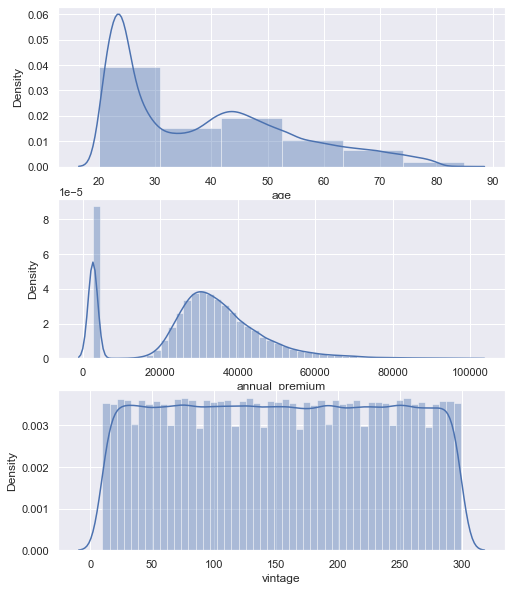

In [21]:
fig, axs = plt.subplots(3, figsize=(8, 10))
sns.distplot(df1['age'],ax=axs[0], bins=6)
sns.distplot(df1[df1['annual_premium']<100000]['annual_premium'],ax=axs[1])
sns.distplot(df1['vintage'],ax=axs[2])

#### <font color = #990775>Categorical Attributes</font>

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

id                      381109
gender                       2
region_code                 53
policy_sales_channel       155
driving_license              2
vehicle_age                  3
vehicle_damage               2
previously_insured           2
response                     2
dtype: int64

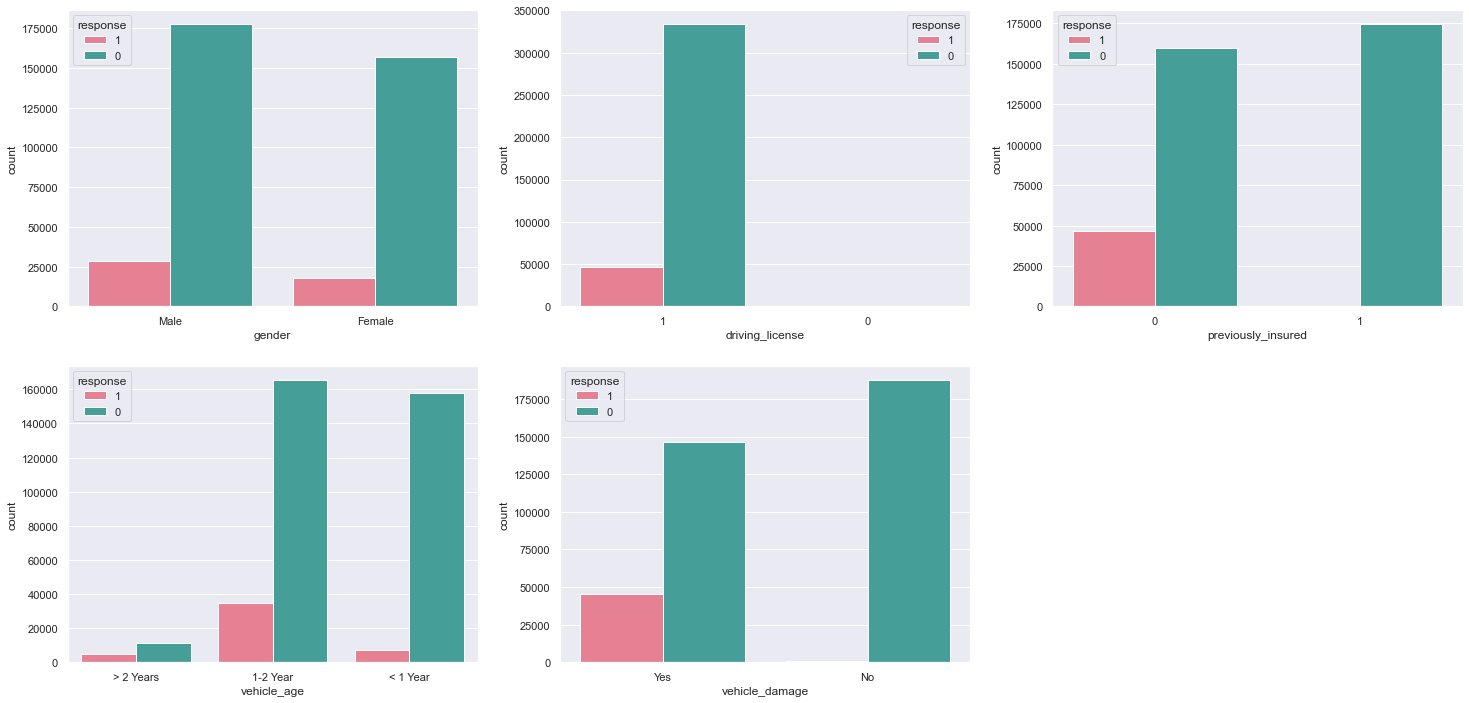

In [84]:
grid = GridSpec(2, 3)

# fig, axs = plt.subplots(ncols=3, figsize=(16, 14))

# plt.subplot(1, 3, 1)
plt.subplot(grid[0, 0])
sns.countplot(data=df1, x='gender', palette="husl", hue='response');

plt.subplot(grid[0, 1])
sns.countplot(data=df1, x='driving_license', palette="husl", hue='response');

plt.subplot(grid[0, 2])
sns.countplot(data=df1, x='previously_insured', palette="husl", hue='response');

plt.subplot(grid[1, 0])
sns.countplot(data=df1, x='vehicle_age', palette="husl", hue='response');

plt.subplot(grid[1, 1])
sns.countplot(data=df1, x='vehicle_damage', palette="husl", hue='response');

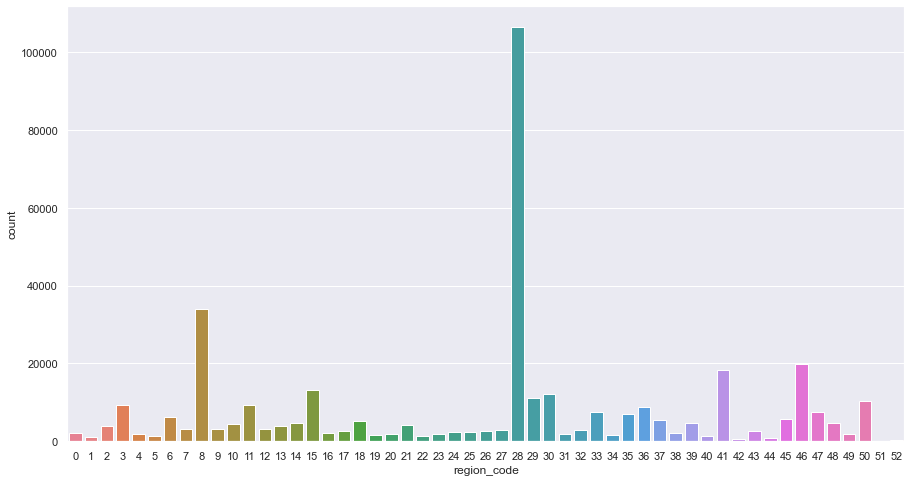

In [24]:
df1['region_code'] = df1['region_code'].astype(int64)
fig = plt.subplots(figsize=(15, 8))
sns.countplot(x='region_code', data=df1.sort_values('region_code', ascending=True), palette="husl");
df1['region_code'] = df1['region_code'].astype(str)

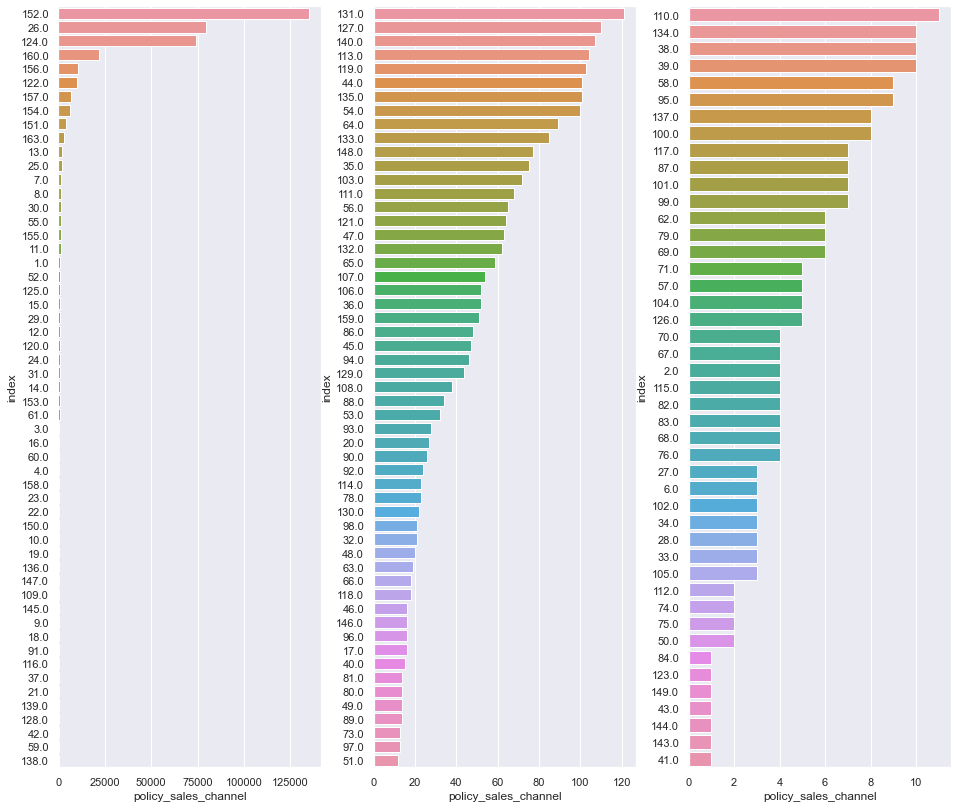

In [25]:
f_channels_1 = df1['policy_sales_channel'].value_counts().iloc[0:55]
f_channels_1 = f_channels_1.reset_index()
f_channels_2 = df1['policy_sales_channel'].value_counts().iloc[55:110]
f_channels_2 = f_channels_2.reset_index()
f_channels_3 = df1['policy_sales_channel'].value_counts().iloc[110:156]
f_channels_3 = f_channels_3.reset_index()

fig, axs = plt.subplots(ncols=3, figsize=(16, 14))
sns.barplot(y = 'index', x = 'policy_sales_channel', data=f_channels_1, ax=axs[0], orient='h', order=f_channels_1['index'])
sns.barplot(y = 'index', x = 'policy_sales_channel', data=f_channels_2, ax=axs[1], orient='h', order=f_channels_2['index'])
sns.barplot(y = 'index', x = 'policy_sales_channel', data=f_channels_3, ax=axs[2], orient='h', order=f_channels_3['index']);

In [26]:
df1.driving_license.value_counts()

1    380297
0       812
Name: driving_license, dtype: int64

#### <font color = #990775>Target Attribute</font>

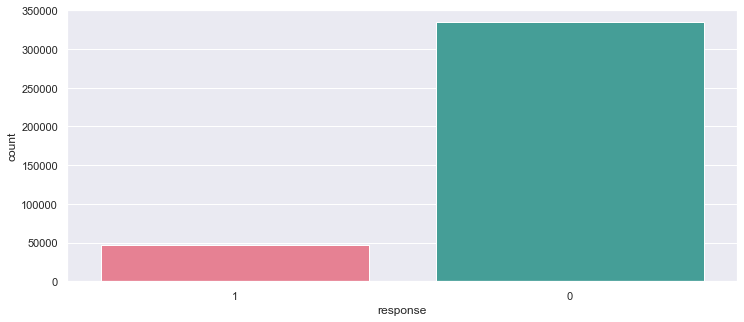

In [27]:
plt.figure(figsize=(12,5))
sns.countplot(data=df1, x='response', palette="husl")
plt.show();

Target attribute is *unbalanced*

- 87.7% is 0 (negative for interest in purchasing a vehicle insurance)
- 12.3% is 1

## <font color = #990775>2 - FEATURE ENGINEERING</font>

In [28]:
df2 = df1.copy()

### <font color = #990775>Mind Map Hypothesis</font>

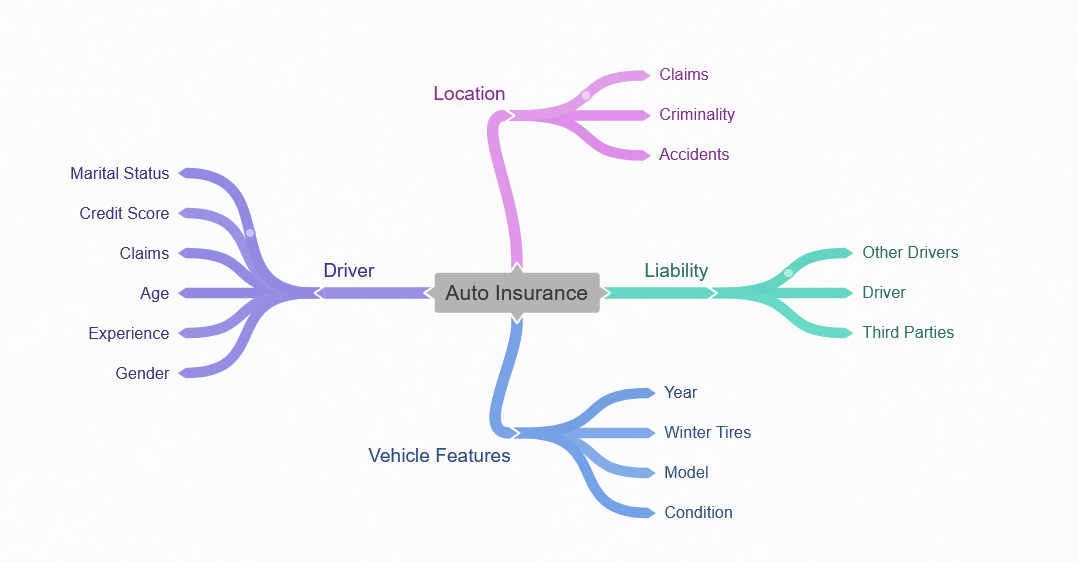

In [29]:
Image("../images/mind_map.png")

### <font color = #990775>Hypothesis Creation</font>

**-** Unlicensed clients would be less likely to purchase auto insurance

**-** Younger clients would be more likely to purchase auto insurance

**-** Female clients would be more likely to purchase auto insurance

**-** Clients who have already had their vehicle damaged would be more likely to purchase auto insurance

**-** Clients who have already been involved in any vehicle accident would be more likely to purchase auto insurance

**-** Clients who have already had their vehicle insured would be more likely to purchase auto insurance

**-** Clients for a longer time at the current brokerage would be more likely to purchase auto insurance

**-** Clients who pay more for health insurance would be more likely to purchase auto insurance

**-** Clients under some specific policy sales channels would be more likely to purchase auto insurance

**-** Clients living in some specific region codes would be more likely to purchase auto insurance

**-** Clients from locations with a high level of claims would be more likely to purchase auto insurance

**-** Clients with more than 2 drivers in the household would be more likely to purchase auto insurance

**-** Clients with older vehicles would be less likely to purchase auto insurance.

#### <font color = #990775>List of discarded hypothesis for not having enough data to be tested</font>

**-** Clients who have already been involved in any vehicle accident would be more likely to purchase auto insurance

**-** Clients with more than 2 drivers in the household would be more likely to purchase auto insurance

**-** Clients from locations with a high level of claims would be more likely to purchase auto insurance

#### <font color = #990775>List of hypothesis to be tested (validate or disproof)</font>

**1.** Unlicensed clients would be less likely to purchase auto insurance

**2.** Younger clients would be more likely to purchase auto insurance

**3.** Female clients would be more likely to purchase auto insurance

**4.** Clients who have already had their vehicle damaged would be more likely to purchase auto insurance

**5.** Clients who have already had their vehicle insured would be more likely to purchase auto insurance

**6.** Clients for a longer time at the current brokerage would be more likely to purchase auto insurance

**7.** Clients who pay more for health insurance would be more likely to purchase auto insurance

**8.** Clients under some specific policy sales channels would be more likely to purchase auto insurance

**9.** Clients living in some specific region codes would be more likely to purchase auto insurance

**10.** Clients with older vehicles would be less likely to purchase auto insurance.

### <font color = #990775>Feature Engineering</font>

In [30]:
df2 = df1.copy()

In [31]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x=='> 2 Years' else 'between_1_2_years' if x=='1-2 Year' else 'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

In [32]:
df2.head(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28,26.0,1,over_2_years,1,0,40454.0,217,1
1,2,Male,76,3,26.0,1,between_1_2_years,0,0,33536.0,183,0
2,3,Male,47,28,26.0,1,over_2_years,1,0,38294.0,27,1
3,4,Male,21,11,152.0,1,below_1_year,0,1,28619.0,203,0
4,5,Female,29,41,152.0,1,below_1_year,0,1,27496.0,39,0


## <font color = #990775>3 - FILTERING FEATURES</font>

Per the descriptive statistics analysis and the business assumptions, no features were considered to be filtered out (no data to be excluded).

## <font color = #990775>4 - EXPLORATORY DATA ANALYSIS (EDA)</font>

In [33]:
df3 = df2.copy()

### <font color = #990775>Univariate Analysis</font>

#### <font color = #990775>Response Variable / Target Attribute</font>

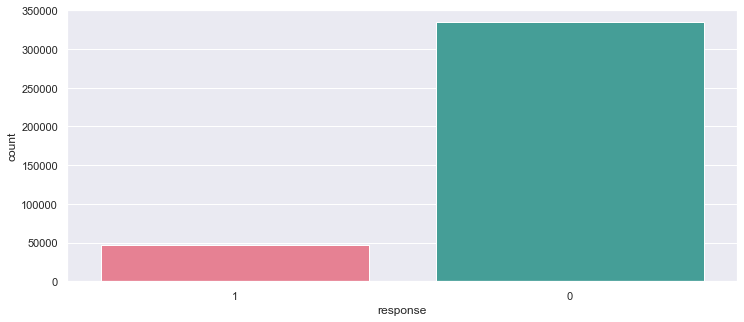

In [34]:
plt.figure(figsize=(12,5))
sns.countplot(data=df3, x='response', palette="husl")
plt.show();

The chart above shows that data is unbalanced in the dataset. For the first round of the data analysis, lets simply watch the variables as they actually are presented.

#### <font color = #990775>Numerical Predictor Variables</font>

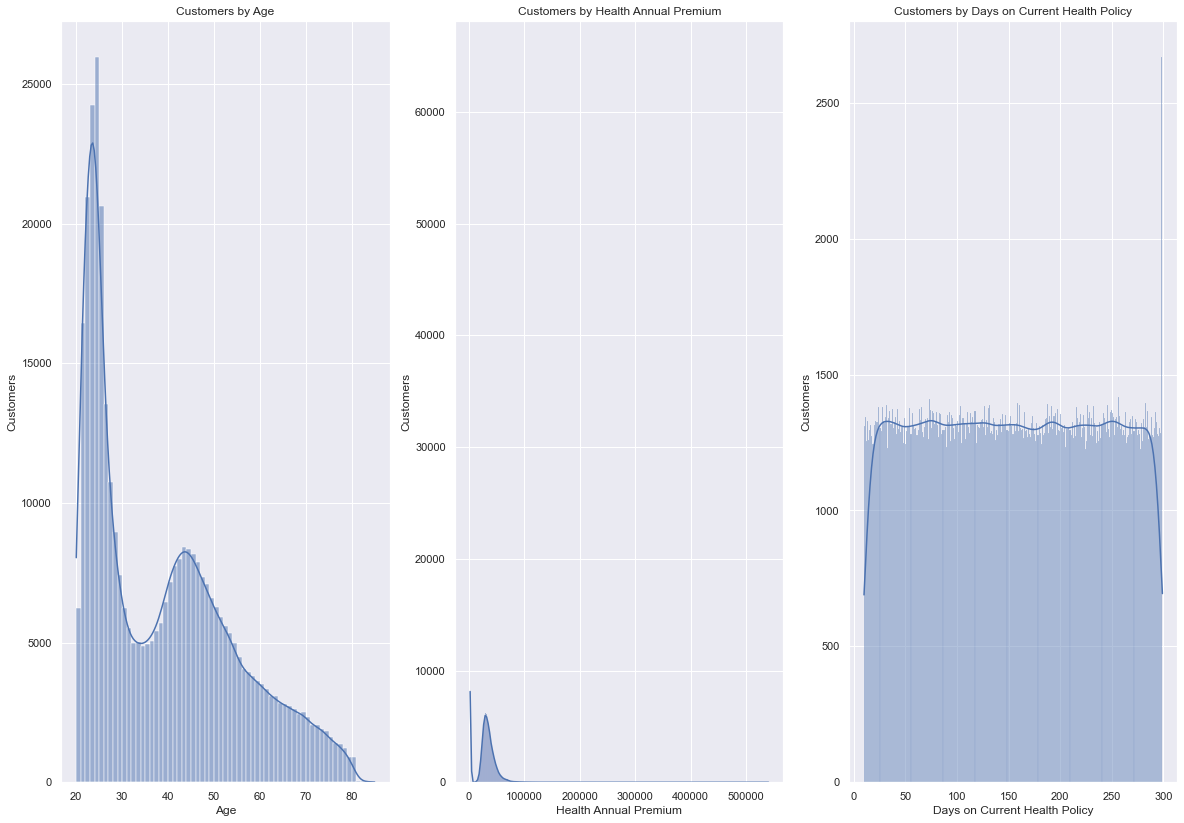

In [35]:
plt.figure(figsize=(20,14))

plt.subplot(1,3,1)
age_hist = sns.histplot(df3['age'], binwidth=1, kde=True);
age_hist.set_ylabel('Customers')
age_hist.set_xlabel('Age')
age_hist.set_title('Customers by Age');

plt.subplot(1,3,2)
hap_hist = sns.histplot(df3['annual_premium'], kde=True);
hap_hist.set_ylabel('Customers')
hap_hist.set_xlabel('Health Annual Premium')
hap_hist.set_title('Customers by Health Annual Premium');

plt.subplot(1,3,3)
da_hist = sns.histplot(df3['vintage'], binwidth=1, kde=True);
da_hist.set_ylabel('Customers')
da_hist.set_xlabel('Days on Current Health Policy')
da_hist.set_title('Customers by Days on Current Health Policy');

#### <font color = #990775>Categorical Predictor Variables</font>

Considering that no features were filtered out, the charts for numerical and predictor variables would be the same as shown in the "Descriptive Analysis" section above.

### <font color = #990775>Bivariate Analysis and Hypotheses Testing</font>

#### <font color = #990775>Hypothesis 1 - Unlicensed clients would be less likely to purchase auto insurance</font>

**TRUE:** Indeed, UNLICENSED clients purchase LESS auto insurance

In [36]:
# driving_license

# changing types to numerical to visualize in some other charts
df3['driving_license'] = df3['driving_license'].astype(int64)

aux = df3[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = round(aux['driving_license'] / aux['driving_license'].sum(), 2)
aux.head()
# it shows clients that have driving license (sum of 1's) for each response
# 88% of licensed clientes doesn't want to get a (new) automobile policy

,response,driving_license,driving_license_perc
0,0,333628,0.88
1,1,46669,0.12


<AxesSubplot:xlabel='response', ylabel='driving_license'>

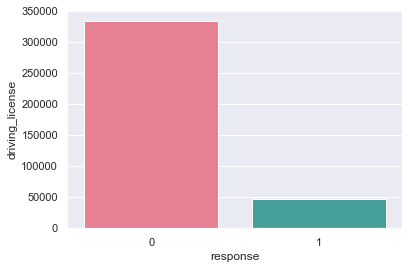

In [37]:
sns.barplot(x='response', y='driving_license', data=aux, palette="husl")

In [38]:
my_crosstab = pd.crosstab(index=df3['response'], columns=df3['driving_license'], margins=True)
my_crosstab

driving_license,0,1,All
response,,,
0,771,333628,334399
1,41,46669,46710
All,812,380297,381109


#### <font color = #990775>Hypothesis 2 - Younger clients would be more likely to purchase auto insurance</font>

**TRUE:** Indeed, YOUNGER clients purchase MORE auto insurance

<AxesSubplot:xlabel='response', ylabel='age'>

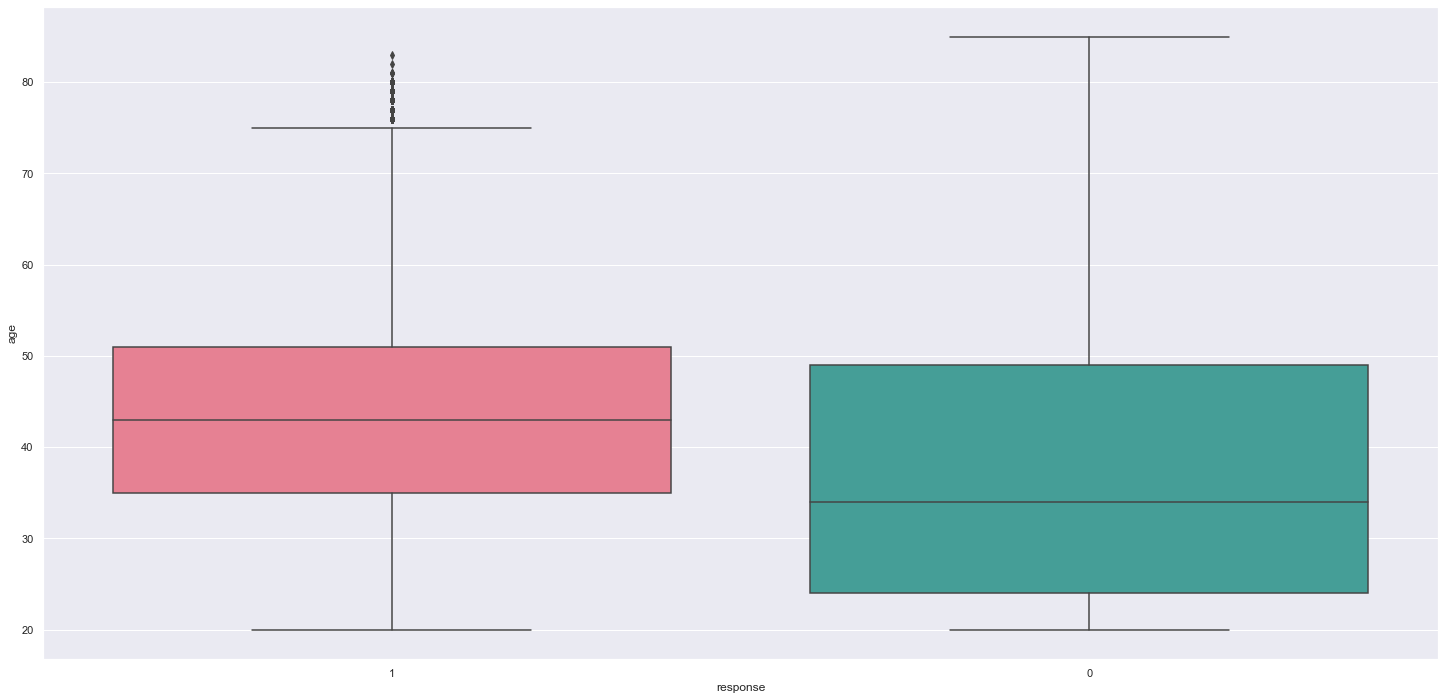

In [39]:
# age
sns.set(rc={'figure.figsize':(25, 12)})
sns.boxplot(x='response', y='age', data=df3, palette="husl")

Comparing the median in both boxplots we would consider 'age' as an important feature for the modelling,
since the customers that replied 'yes' are around 45 years old while the median for 'no' is around 35. 
Now, considering that age is a continuous variable, lets analyse it in another format (histogram):

<AxesSubplot:xlabel='age', ylabel='Count'>

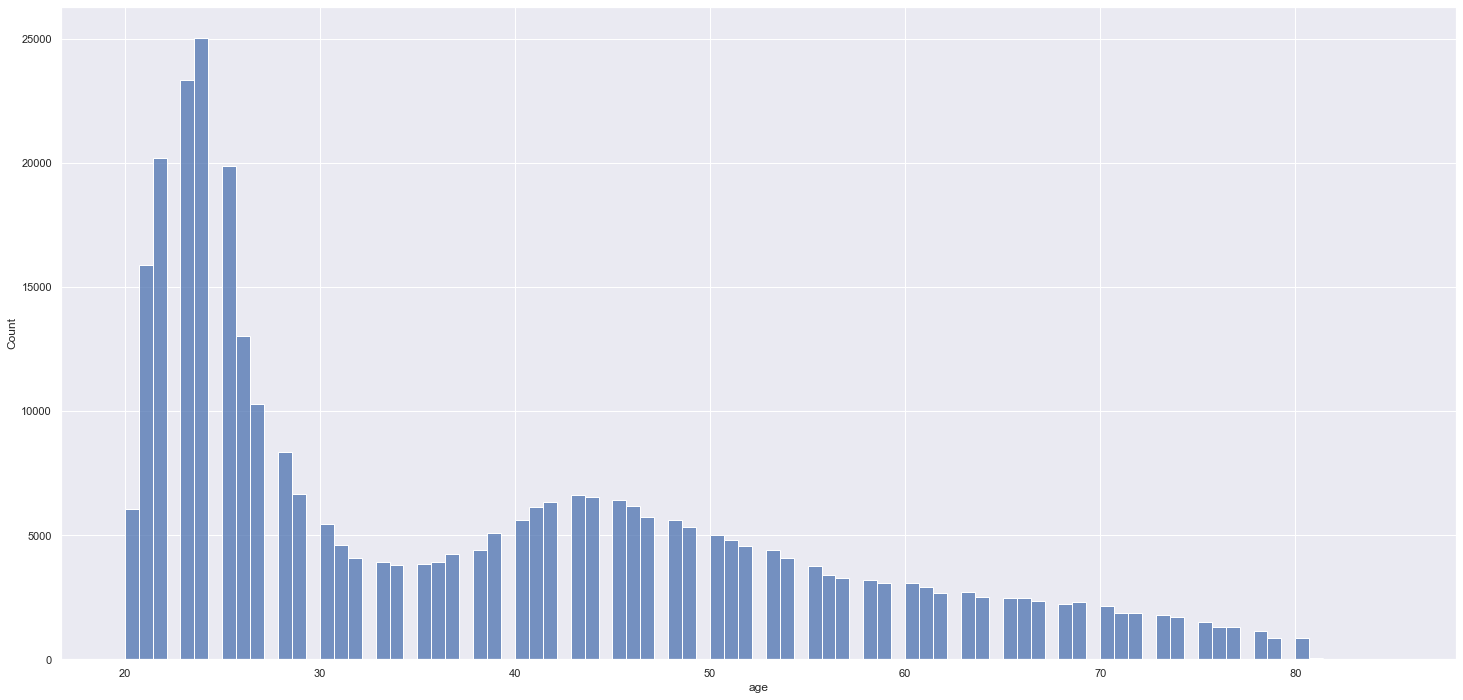

In [40]:
df3['response'] = df3['response'].astype(int64)
aux00 = df3.loc[df3['response'] == 0, 'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

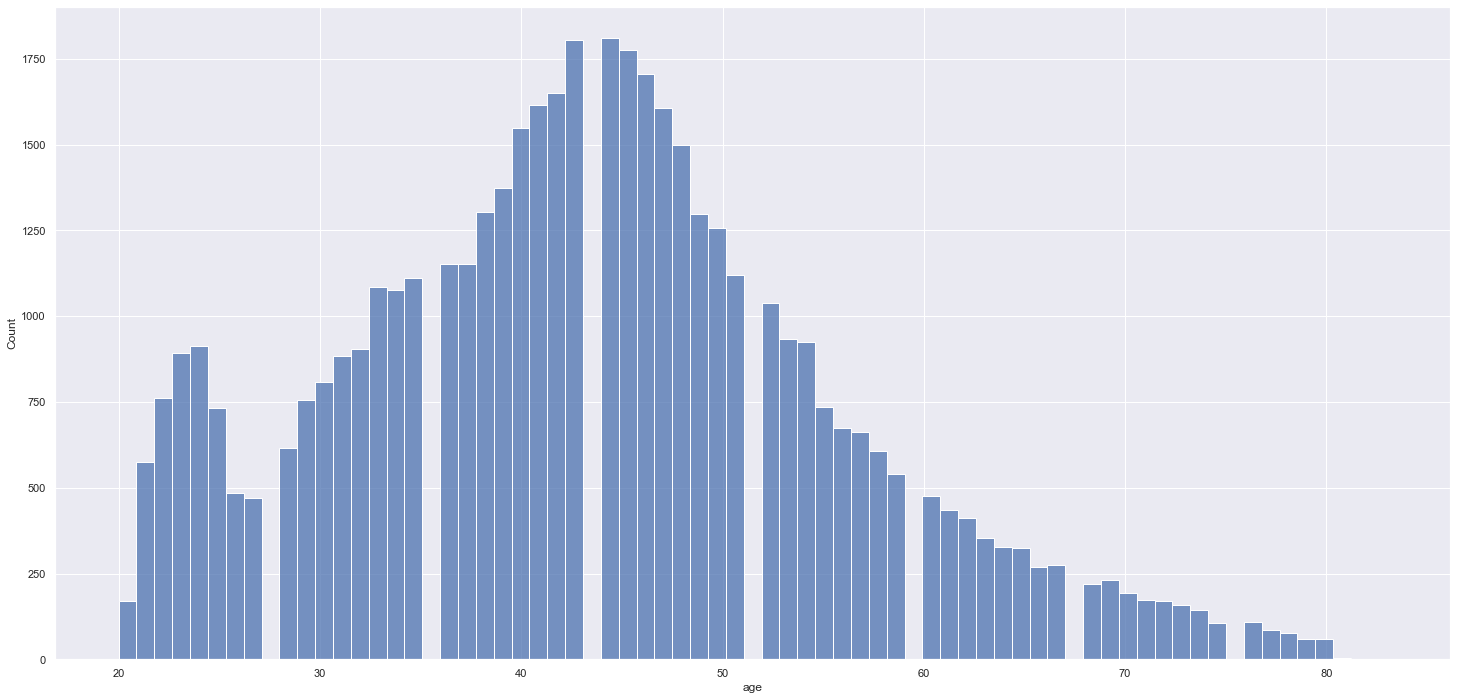

In [41]:
aux00 = df3.loc[df3['response'] == 1, 'age']
sns.histplot(aux00)

#### <font color = #990775>Hypothesis 3 - Female clients would be more likely to purchase auto insurance</font>

**FALSE:** Actually, MALE clients purchase MORE auto insurance

In [42]:
# gender
df3[['gender', 'response']].value_counts(normalize=True).reset_index().sort_values('gender', ascending=True)

,gender,response,0
1,Female,0,0.411523
3,Female,1,0.047716
0,Male,0,0.465914
2,Male,1,0.074847


#### <font color = #990775>Hypothesis 4 - Clients who have already had their vehicle damaged would be more likely to purchase auto insurance</font>

**FALSE:** Actually, clients with VEHICLE DAMAGED IN THE PAST purchase LESS auto insurance

In [43]:
# vehicle_damage

# changing types to numerical to visualize in some other charts
df3['vehicle_damage'] = df3['vehicle_damage'].astype(int64)

aux = df3[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
aux['vehicle_damage_perc'] = round(aux['vehicle_damage'] / aux['vehicle_damage'].sum(), 2)
aux.head()
# it shows clients that already had their vehicle damaged (sum of 1's) for each response
# 76% of such clientes doesn't want to get a (new) automobile policy

,response,vehicle_damage,vehicle_damage_perc
0,0,146685,0.76
1,1,45728,0.24


<AxesSubplot:xlabel='response', ylabel='vehicle_damage'>

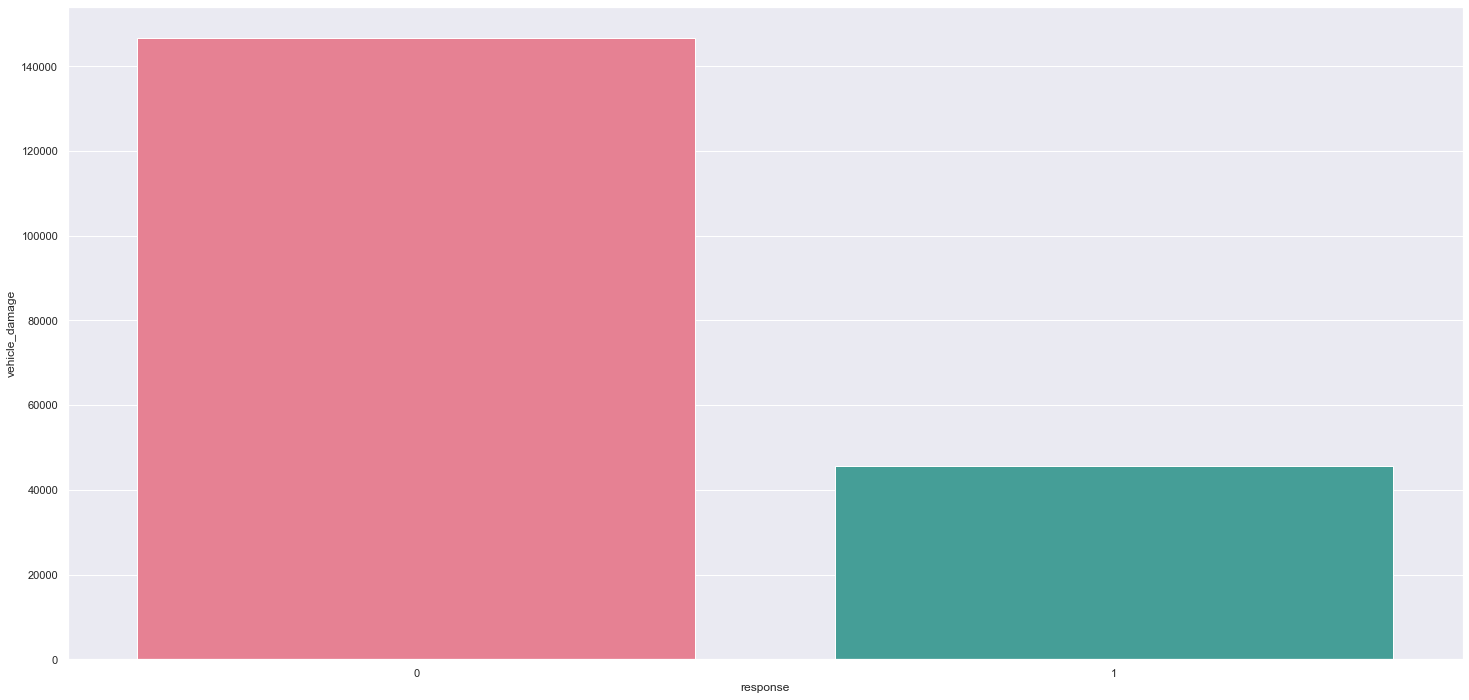

In [44]:
sns.barplot(x='response', y='vehicle_damage', data=aux, palette="husl")

In [45]:
my_crosstab = pd.crosstab(index=df3['response'], columns=df3['vehicle_damage'], margins=True)
my_crosstab

vehicle_damage,0,1,All
response,,,
0,187714,146685,334399
1,982,45728,46710
All,188696,192413,381109


#### <font color = #990775>Hypothesis 5 - Clients who have already had their vehicle insured would be more likely to purchase auto insurance</font>

**FALSE:** Actually, PREVIOUSLY INSURED clients purchase LESS auto insurance.

The assumption here is that client is currently insured under other carrier and/or is not interested in changing the brokerage.

In [46]:
# previously_insured
pd.crosstab(df3['previously_insured'], df3['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


#### <font color = #990775>Hypothesis 6 - Clients for a longer time at the current brokerage would be more likely to purchase auto insurance</font>

**FALSE:** Actually, CURRENT HEALTH INSURANCE clients are just as likely to purchase auto insurance.

The dataset considered only the time at the current one-year health insurance term, so the days go from 1 to 365.
For the next cicles of CRISP, actual vintage time should be considered (i.e. years).

<AxesSubplot:xlabel='response', ylabel='vintage'>

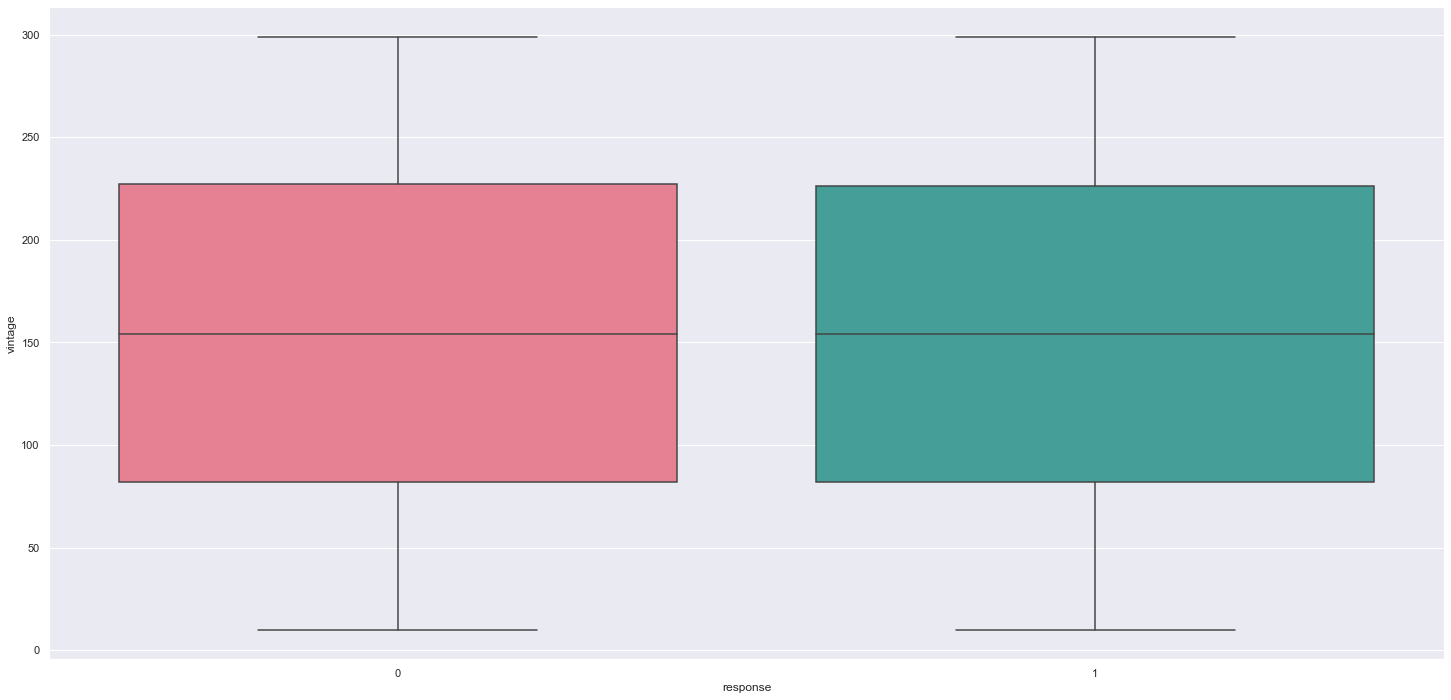

In [47]:
# vintage
sns.boxplot(x='response', y='vintage', data=df3, palette="husl")

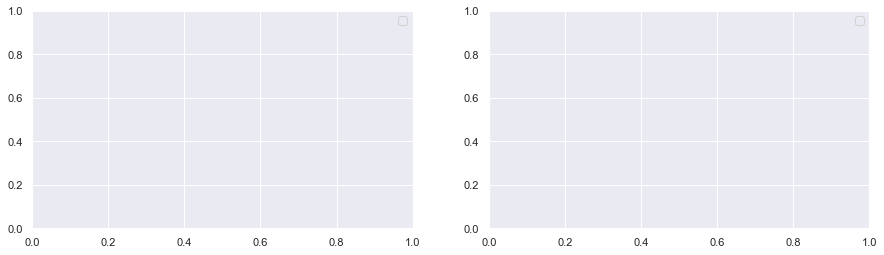

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
sns.histplot(df3[df3['response']=='0']['vintage'], kde=False, label='response 0', ax=axs[0])
axs[0].legend(labels=['response 0'])
sns.histplot(df3[df3['response']=='1']['vintage'], kde=False, label='response 1', ax=axs[1])
axs[1].legend(labels=['response 1'])

#### <font color = #990775>Hypothesis 7 - Clients who pay more for health insurance would be more likely to purchase auto insurance</font>

**FALSE:** Actually, ANNUAL PREMIUM FOR HEALTH INSURANCE doesn't have any clear impact at the decision to purchase auto insurance. Despite of data being unbalanced, there is no clear difference between the two outputs.

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

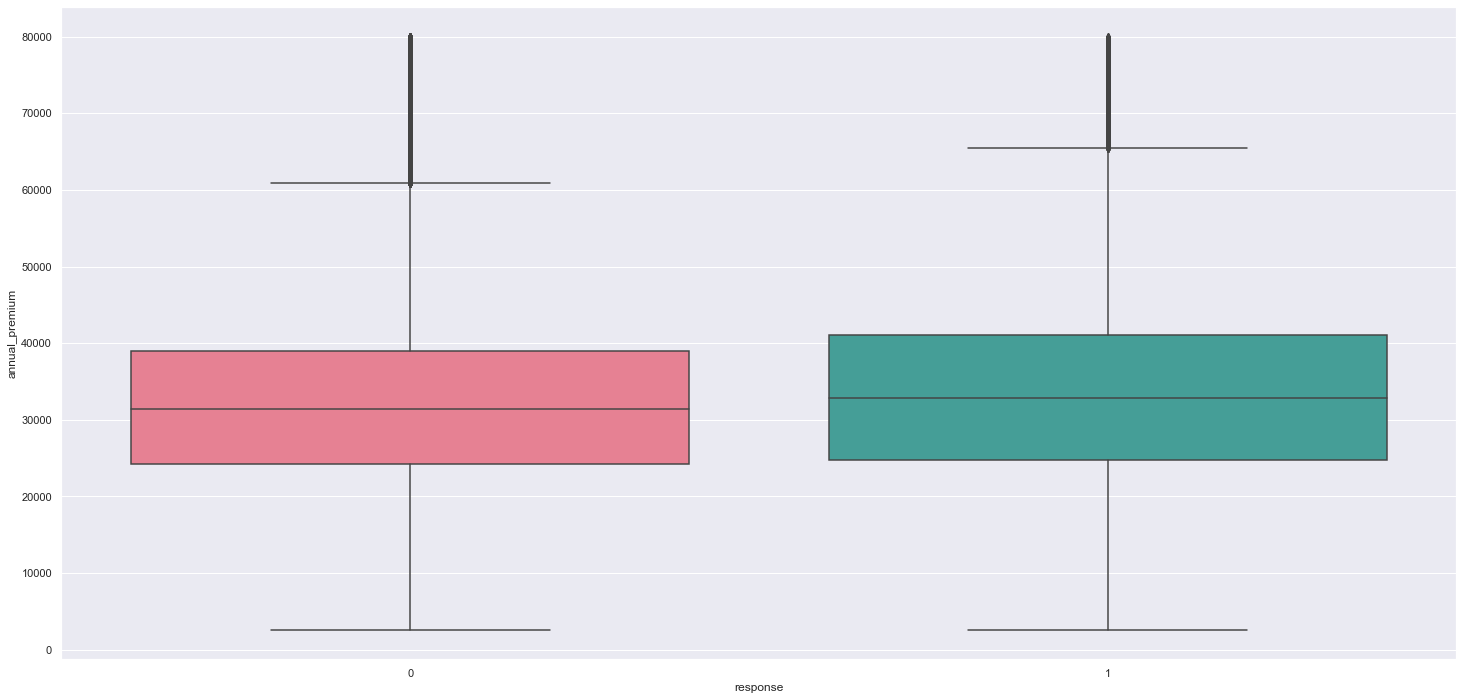

In [49]:
# annual_premium

# zoom in to better visualize
aux = df3[df3['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux, palette="husl")

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

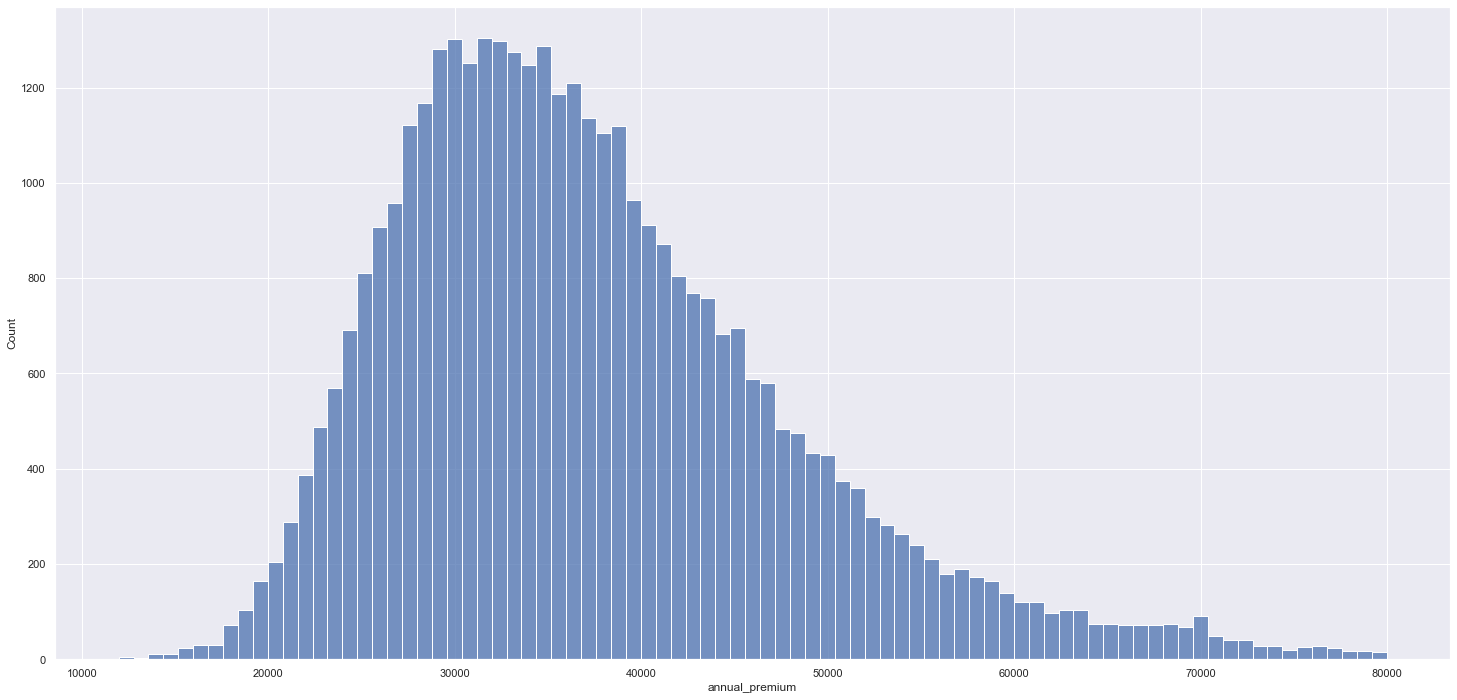

In [86]:
aux = df3[(df3['annual_premium'] > 10000) & (df3['annual_premium'] < 80000)]
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

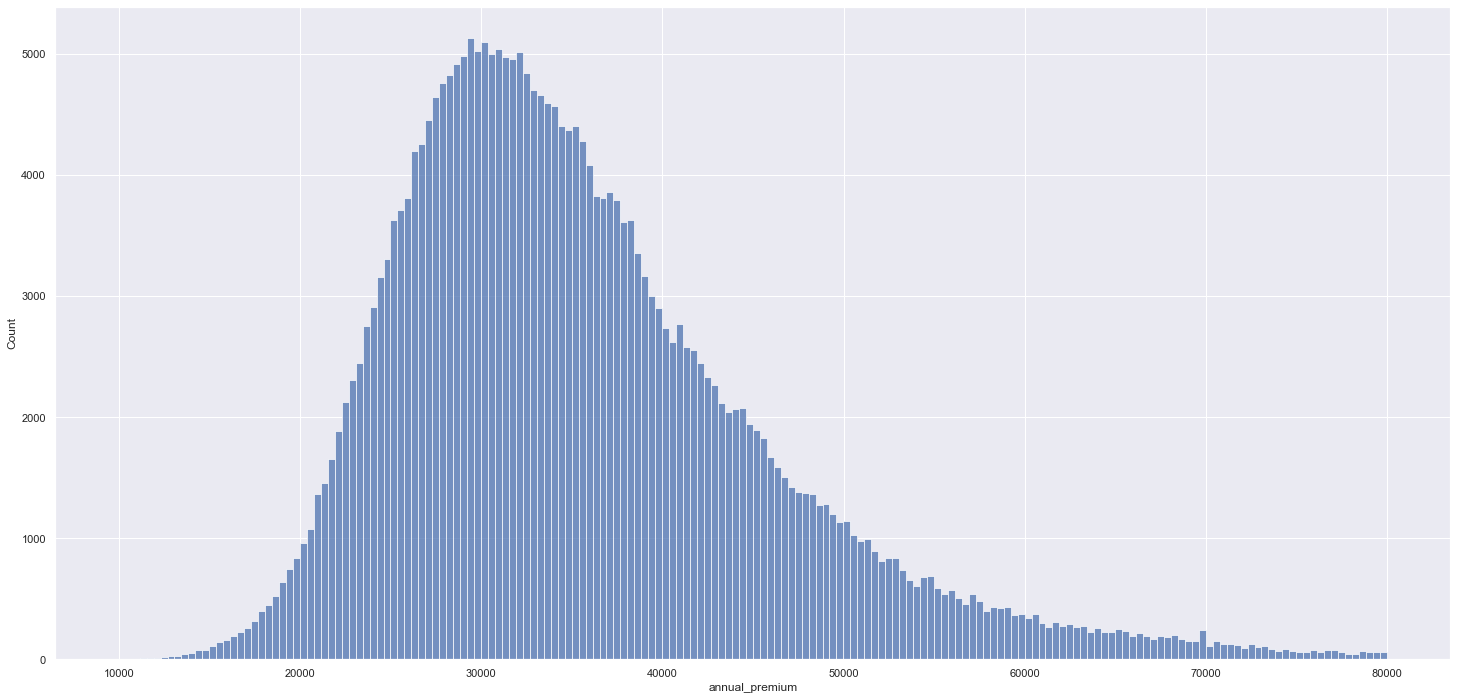

In [87]:
aux = df3[(df3['annual_premium'] > 10000) & (df3['annual_premium'] < 80000)]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00)

#### <font color = #990775>Hypothesis 8 - Clients under some specific policy sales channels would be more likely to purchase auto insurance</font>

**FALSE:** Actually, the different 155 POLICY SALES CHANNELS look just as likely to influence the purchase of auto insurance.

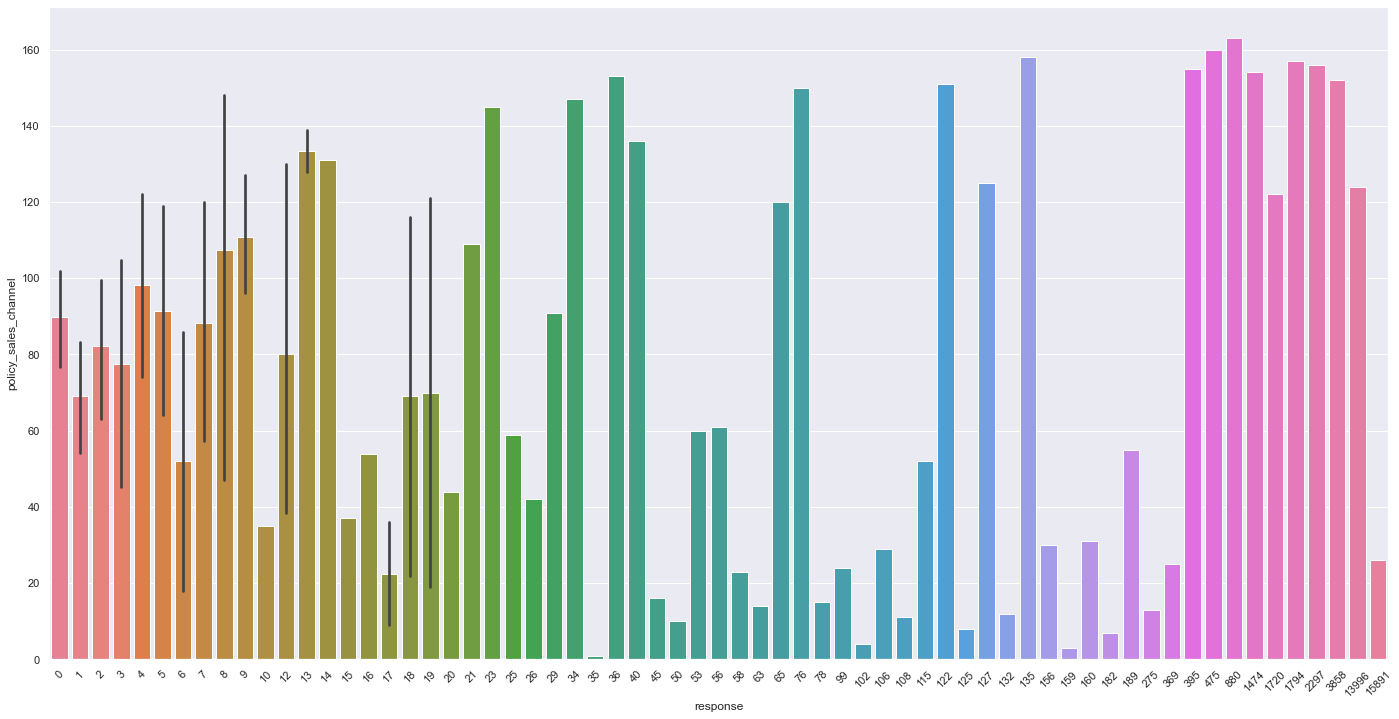

In [52]:
# policy sales channel
df3['response'] = df3['response'].astype(int64)
df3['policy_sales_channel'] = df3['policy_sales_channel'].astype(float64)
plt.figure(figsize=(24, 12))
aux = df3[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux, palette="husl");
plt.xticks(rotation=45);

In [53]:
# change back to categorical type
df3['policy_sales_channel'] = df3['policy_sales_channel'].astype(str)

#### <font color = #990775>Hypothesis 9 - Clients living in some specific region codes would be more likely to purchase auto insurance.</font>

**FALSE:** Actually, the different 53 REGION CODES look just as likely to influence the purchase of auto insurance.

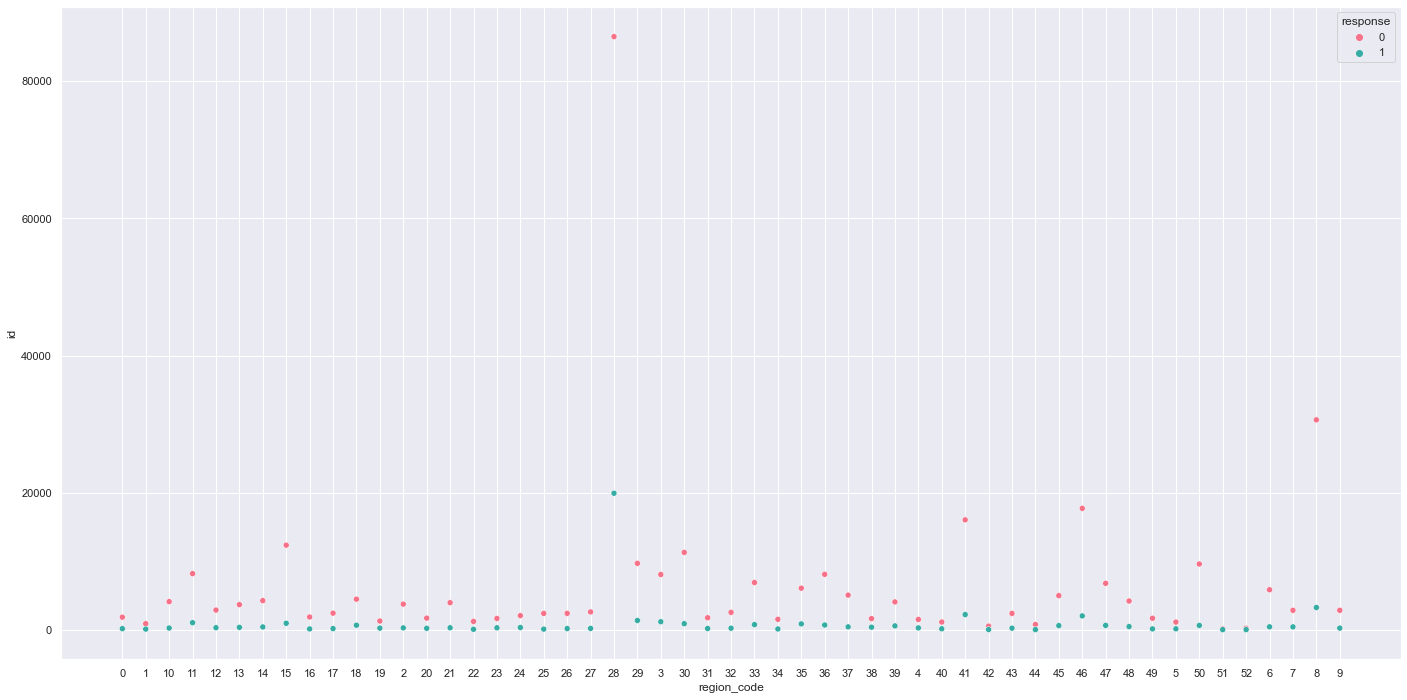

In [54]:
# region_code
aux0 = df3[['id','region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
plt.figure(figsize=(24, 12))
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0, palette="husl");

#### <font color = #990775>Hypothesis 10 - Clients with older vehicles would be less likely to purchase auto insurance.</font>

**TRUE:** Indeed, clients with OLDER VEHICLES purchase LESS auto insurance.

In [55]:
pd.crosstab(df3['vehicle_age'], df3['response']).apply(lambda x: x/x.sum(), axis=1).sort_values('vehicle_age', ascending=True)

response,0,1
vehicle_age,,
below_1_year,0.956295,0.043705
between_1_2_years,0.826245,0.173755
over_2_years,0.706254,0.293746


#### <font color = #990775>Hypotheses Summary</font>

In [82]:
tab = [['HIPOTHESIS', 'CONCLUSION', 'RELEVANCE'],

       ['H1 Unlicensed clients are less likely', 'True', 'High'],
       ['H2 Younger clients are more likely', 'True', 'Medium'],
       ['H3 Female clients are more likely', 'False', 'Medium'],
       ['H4 Clients who already had their vehicle damaged are more likely', 'False', 'High'],
       ['H5 Clients who already had their vehicle insured are more likely', 'False', 'High'],
       ['H6 Clients for a longer time at the current brokerage are more likely', 'False', 'Low'],
       ['H7 Clients who pay more for health insurance are more likely', 'False', 'Low'],
       ['H8 Clients under some specific policy sales channels are more likely', 'False', 'Low'],
       ['H9 Clients living in some specific region codes are more likely', 'False', 'Low'],
       ['H10 Clients with older vehicles are less likely', 'True', 'High'],

]
print("\nLIKELIHOOD TO PURCHASE AUTO INSURANCE:\n")
print(tabulate(tab, headers='firstrow', tablefmt='fancy_grid'))


LIKELIHOOD TO PURCHASE AUTO INSURANCE:

╒═══════════════════════════════════════════════════════════════════════╤══════════════╤═════════════╕
│ HIPOTHESIS                                                            │ CONCLUSION   │ RELEVANCE   │
╞═══════════════════════════════════════════════════════════════════════╪══════════════╪═════════════╡
│ H1 Unlicensed clients are less likely                                 │ True         │ High        │
├───────────────────────────────────────────────────────────────────────┼──────────────┼─────────────┤
│ H2 Younger clients are more likely                                    │ True         │ Medium      │
├───────────────────────────────────────────────────────────────────────┼──────────────┼─────────────┤
│ H3 Female clients are more likely                                     │ False        │ Medium      │
├───────────────────────────────────────────────────────────────────────┼──────────────┼─────────────┤
│ H4 Clients who already had the

### <font color = #990775>Multivariate Analysis</font>

In [57]:
num_attributes = df3.select_dtypes(include=['int64', 'float64'])
cat_attributes = df3.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### <font color = #990775>Numerical Attributes</font>

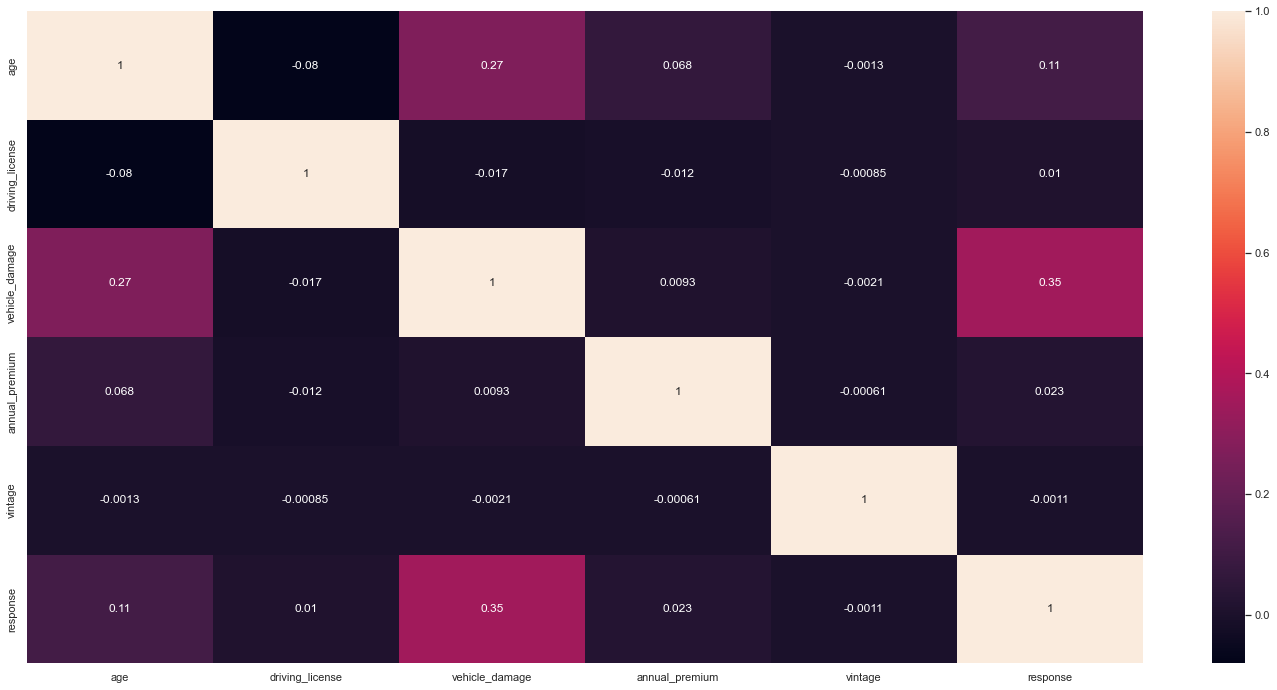

In [58]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

#### <font color = #990775>Categorical Attributes</font>

In [59]:
df3.dtypes

id                       object
gender                   object
age                       int64
region_code              object
policy_sales_channel     object
driving_license           int64
vehicle_age              object
vehicle_damage            int64
previously_insured       object
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

<AxesSubplot:>

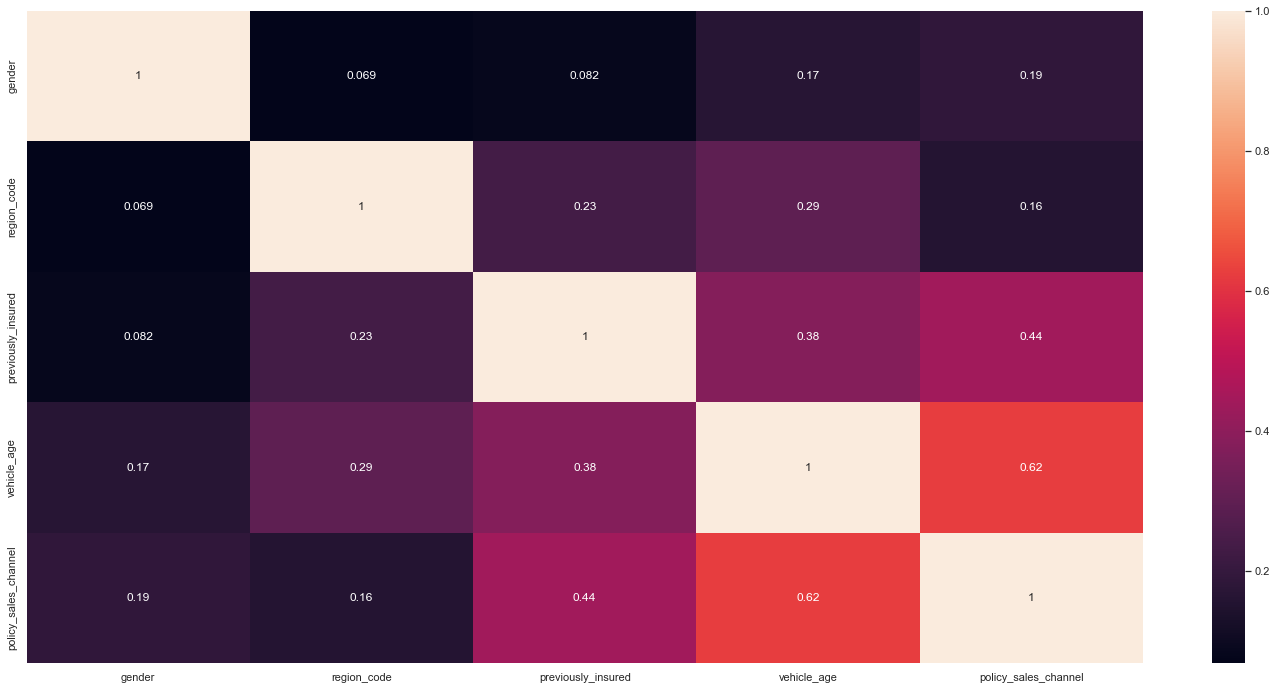

In [60]:
a = df3.select_dtypes(include='object')

# Calculate Cramer V

a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['region_code'])
a3 = cramer_v(a['gender'], a['previously_insured'])
a4 = cramer_v(a['gender'], a['vehicle_age'])
a5 = cramer_v(a['gender'], a['policy_sales_channel'])

a6 = cramer_v(a['region_code'], a['gender'])
a7 = cramer_v(a['region_code'], a['region_code'])
a8 = cramer_v(a['region_code'], a['previously_insured'])
a9 = cramer_v(a['region_code'], a['vehicle_age'])
a10 = cramer_v(a['region_code'], a['policy_sales_channel'])

a11 = cramer_v(a['previously_insured'], a['gender'])
a12 = cramer_v(a['previously_insured'], a['region_code'])
a13 = cramer_v(a['previously_insured'], a['previously_insured'])
a14 = cramer_v(a['previously_insured'], a['vehicle_age'])
a15 = cramer_v(a['previously_insured'], a['policy_sales_channel'])

a16 = cramer_v(a['vehicle_age'], a['gender'])
a17 = cramer_v(a['vehicle_age'], a['region_code'])
a18 = cramer_v(a['vehicle_age'], a['previously_insured'])
a19 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a20 = cramer_v(a['vehicle_age'], a['policy_sales_channel'])

a21 = cramer_v(a['policy_sales_channel'], a['gender'])
a22 = cramer_v(a['policy_sales_channel'], a['region_code'])
a23 = cramer_v(a['policy_sales_channel'], a['previously_insured'])
a24 = cramer_v(a['policy_sales_channel'], a['vehicle_age'])
a25 = cramer_v(a['policy_sales_channel'], a['policy_sales_channel'])

# Compose dataset
d = pd.DataFrame({'gender': [a1, a2, a3, a4, a5],
                 'region_code': [a6, a7, a8, a9, a10],
                 'previously_insured': [a11, a12, a13, a14, a15],
                 'vehicle_age': [a16, a17, a18, a19, a20],
                 'policy_sales_channel': [a21, a22, a23, a24, a25]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

#### <font color = #990775>EDA with SweetViz</font>

In [90]:
report = sv.analyze(df3, target_feat='response')
report.show_html(filepath='../reports/SWEETVIZ_REPORT.html', open_browser=False)

                                             |                                                                …

Report ../reports/SWEETVIZ_REPORT.html was generated.



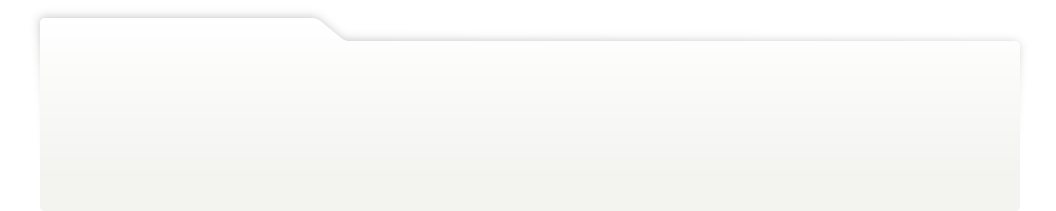
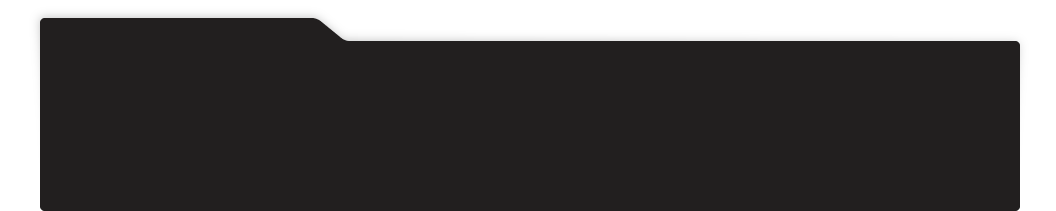
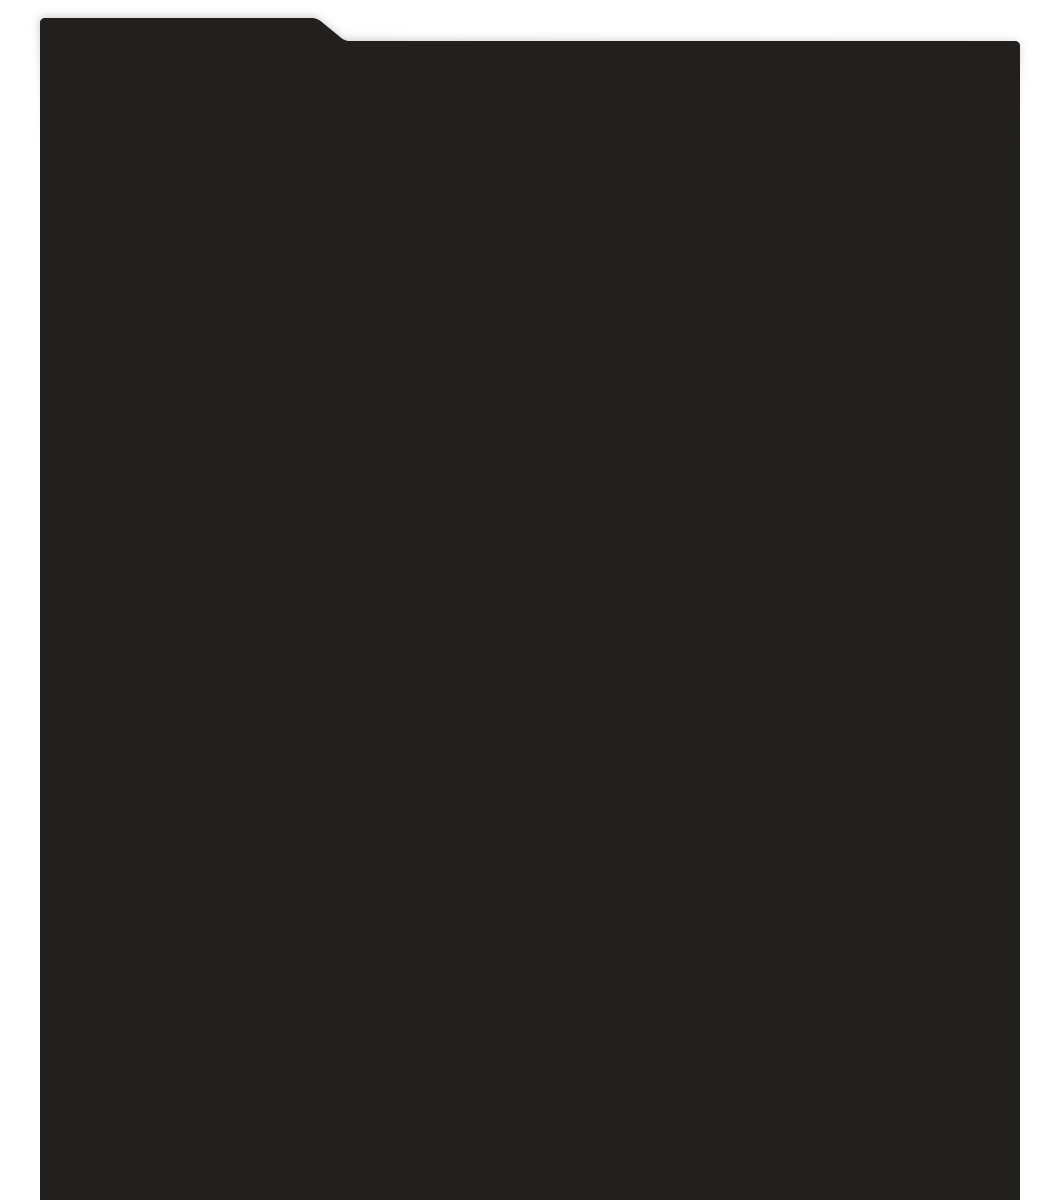
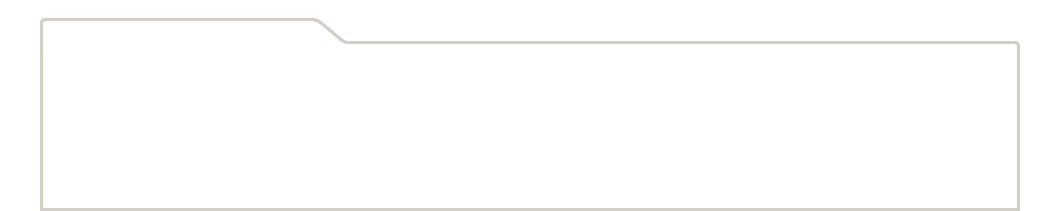
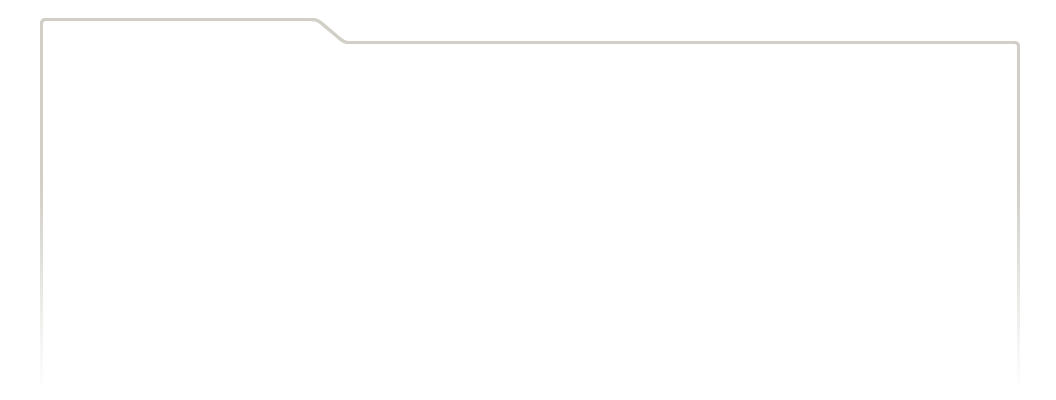
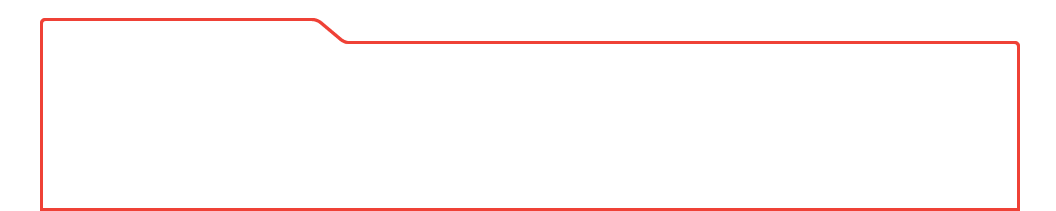
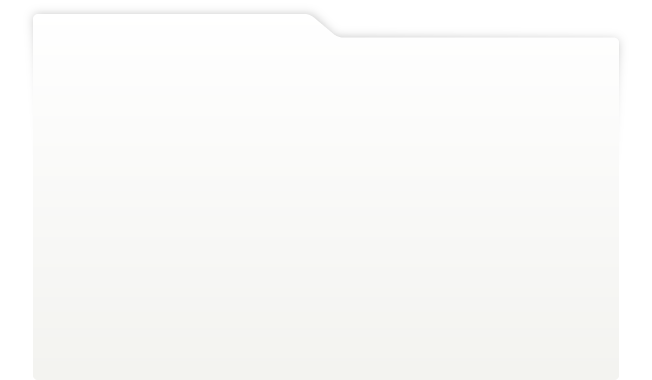
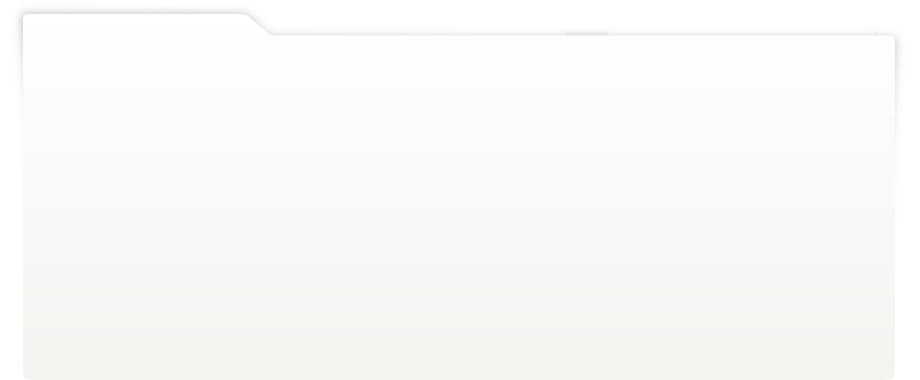
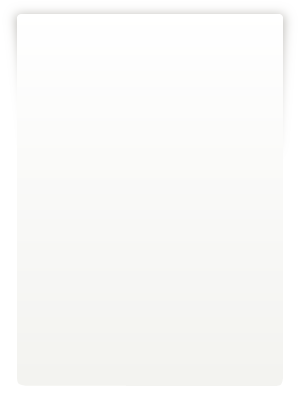
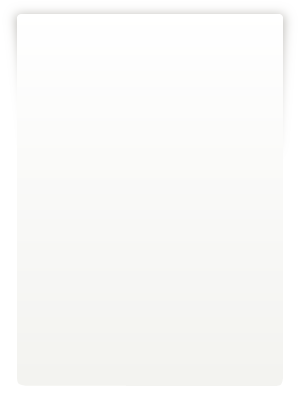
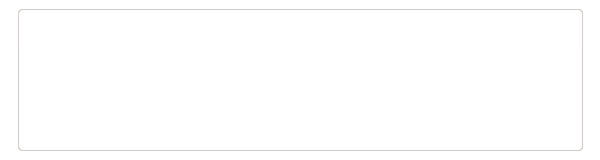
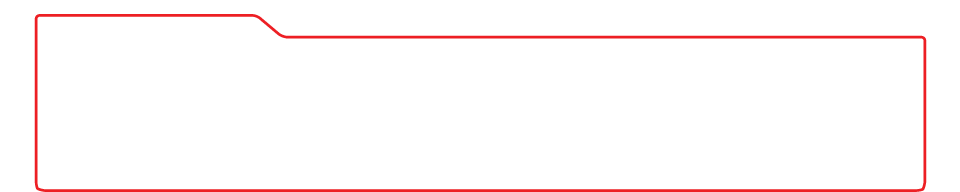
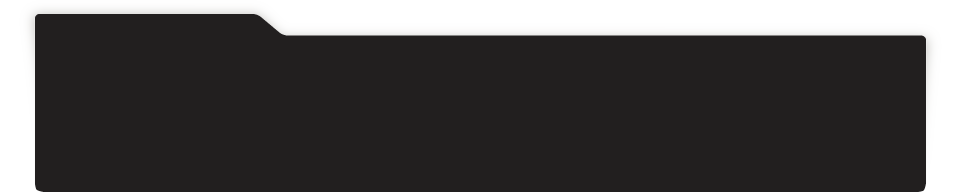
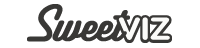
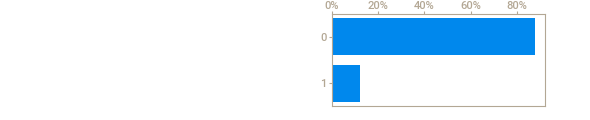
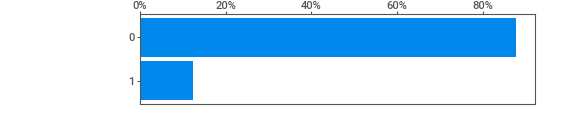
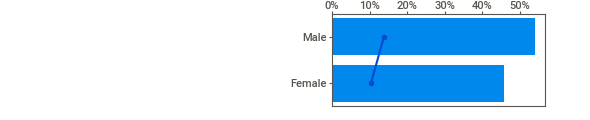
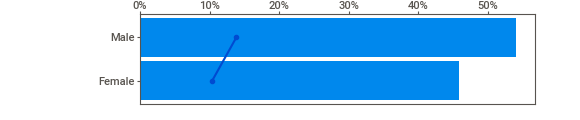
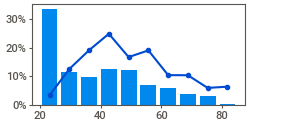
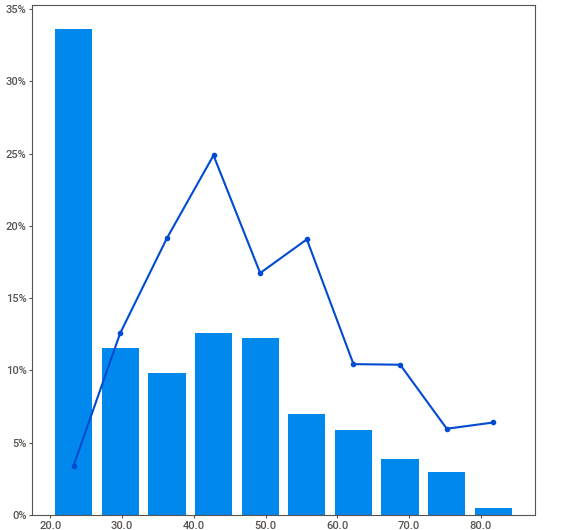
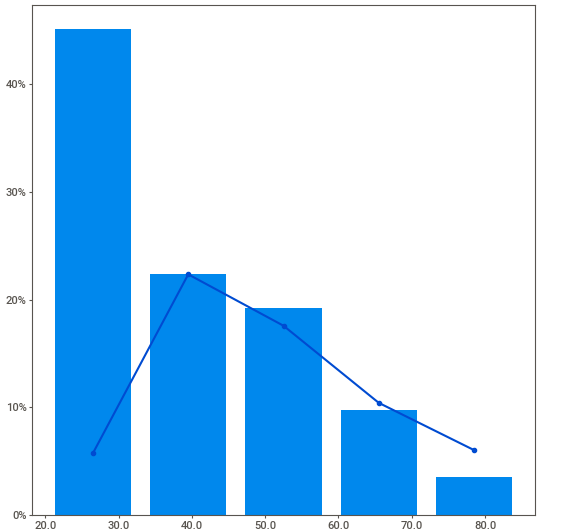
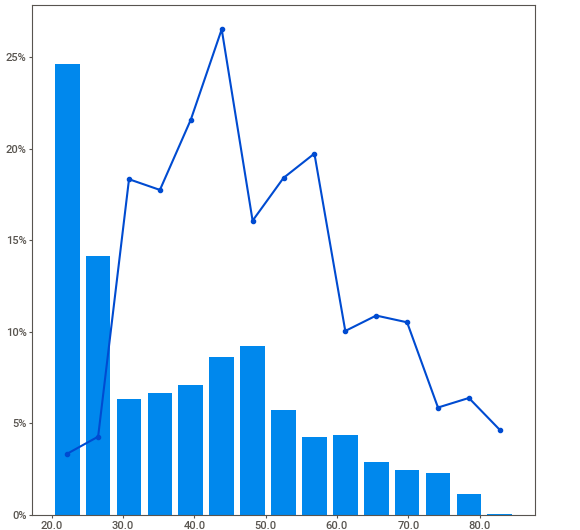
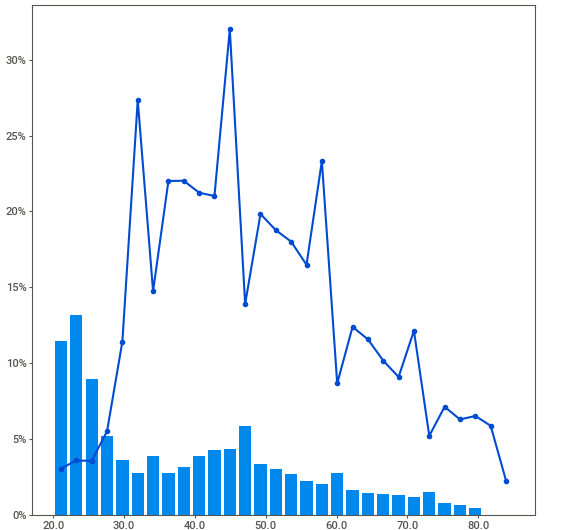
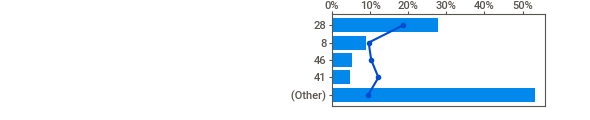
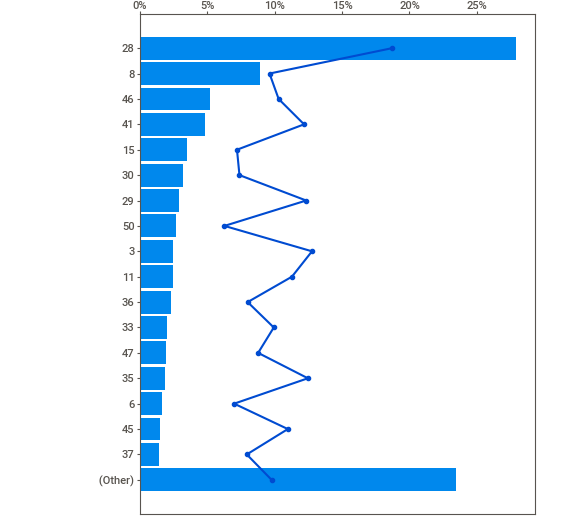
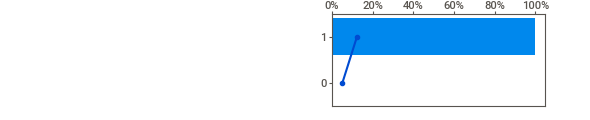
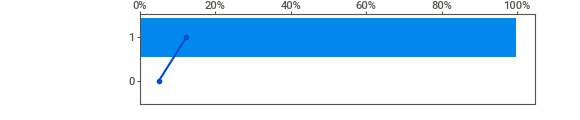
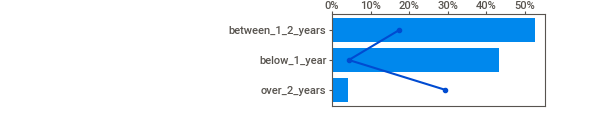
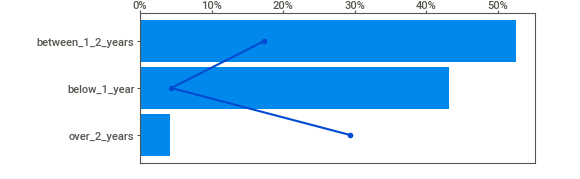
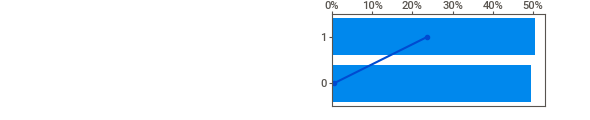
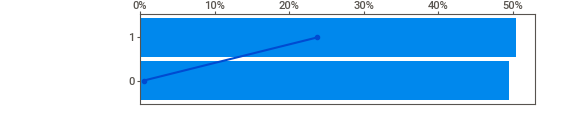
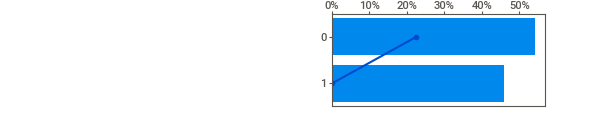
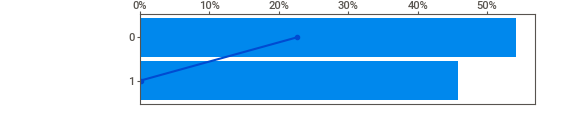
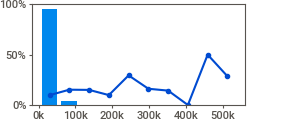
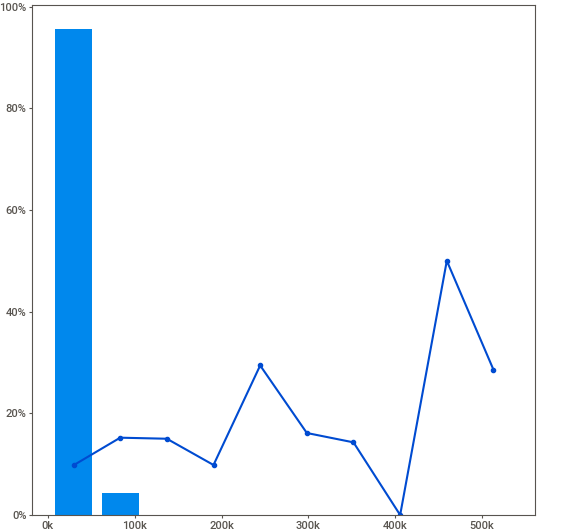
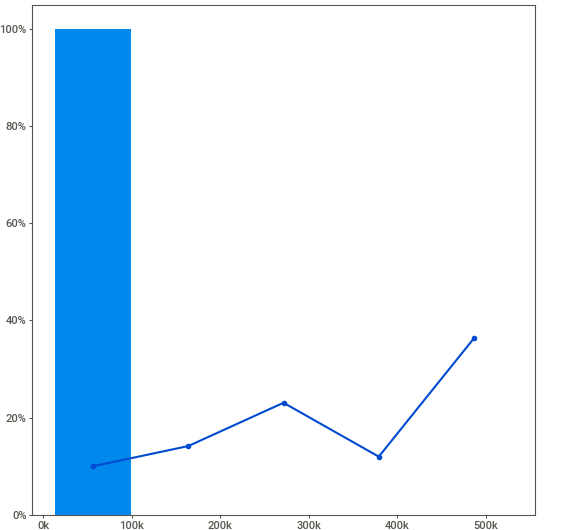
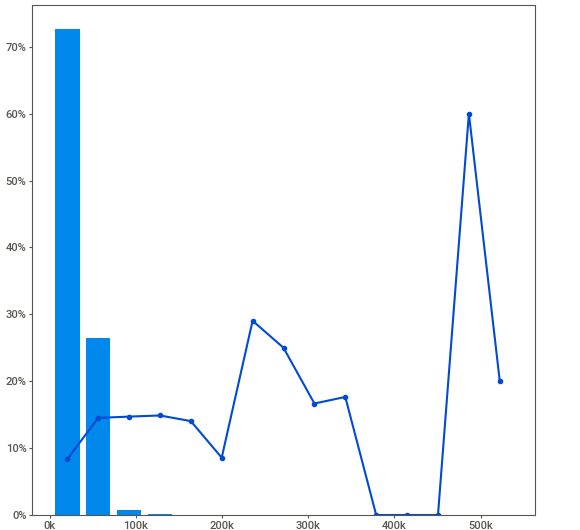
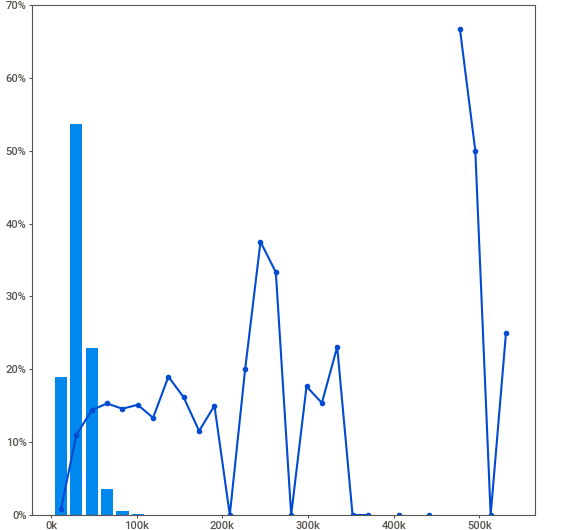
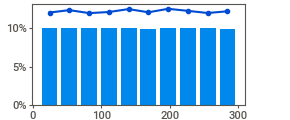
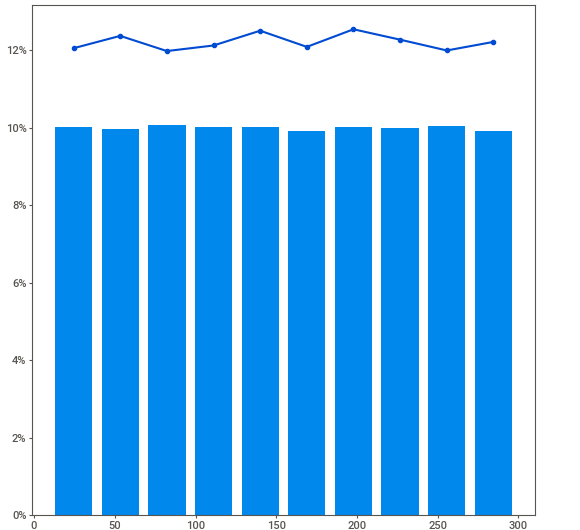
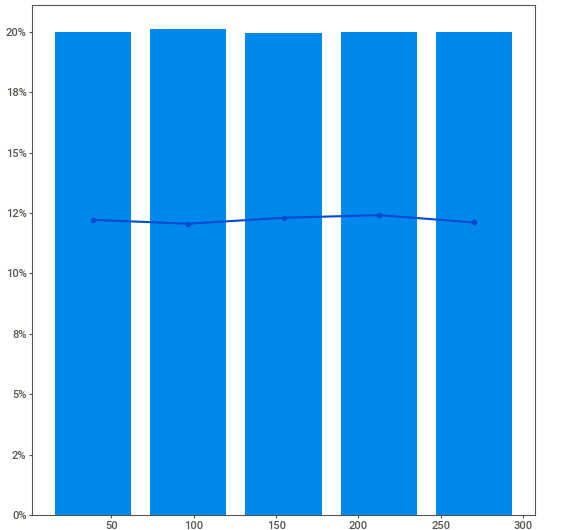
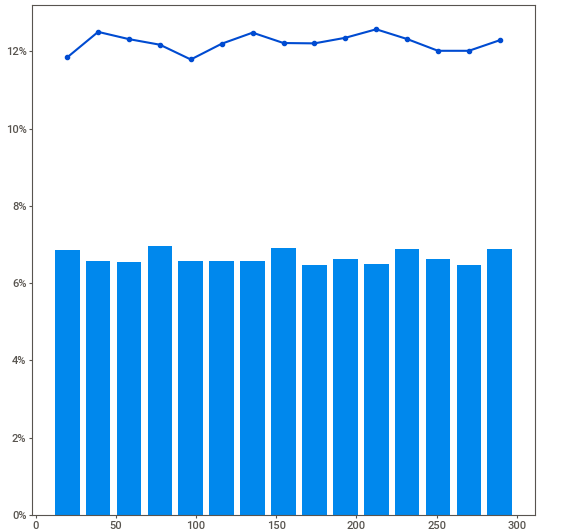
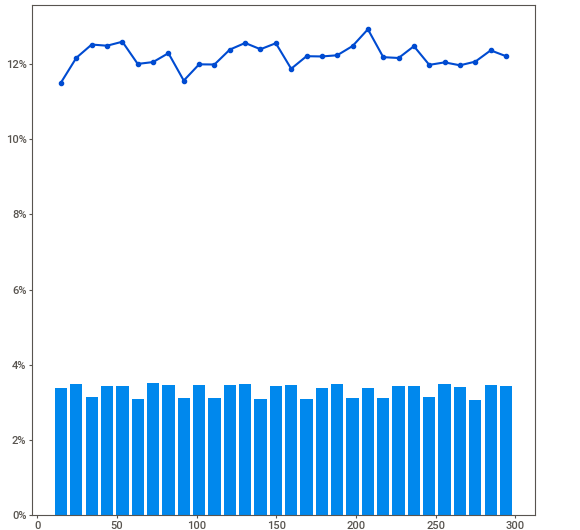
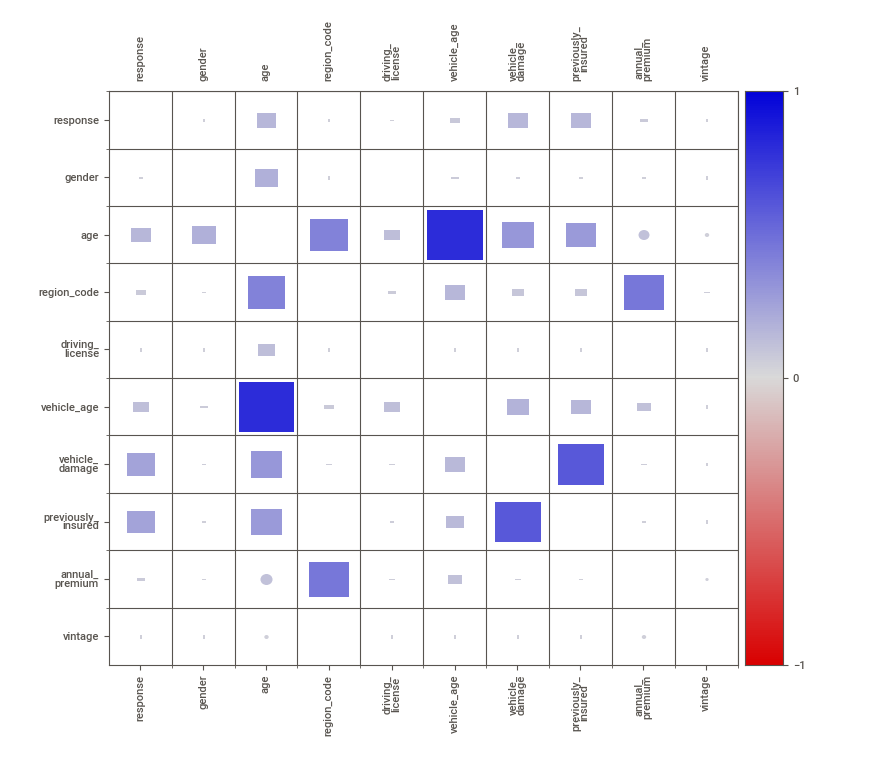
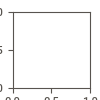

In [91]:
# display on the notebook
report.show_notebook(w=None, h=None, scale=None, layout='vertical')

## <font color = #990775>5 - DATA PREPARATION</font>

#### <font color = #990775>Split data into training and validation</font>

In [61]:
X = df3.drop('response', axis=1)
y = df3['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

df4 = pd.concat([x_train, y_train], axis=1)

In [62]:
df4.shape

(304887, 12)

Many machine learning algorithms perform better whith numerical input variables and also scaled to a standard range, so we are going to prepare the dataset for that. 

#### <font color = #990775>Standardization</font>

In [63]:
# annual premium
ss_annual_premium = pp.StandardScaler()
df4['annual_premium'] = ss_annual_premium.fit_transform(df4[['annual_premium']].values)
pickle.dump(ss_annual_premium, open('../parameters/annual_premium_scaler.pkl', 'wb'))

#### <font color = #990775>Rescaling</font>

In [64]:
# age
mms_age = pp.MinMaxScaler()
df4['age'] = mms_age.fit_transform(df4[['age']].values)
pickle.dump(mms_age, open('../parameters/age_scaler.pkl', 'wb'))

# vintage
mms_vintage = pp.MinMaxScaler()
df4['vintage'] = mms_vintage.fit_transform(df4[['vintage']].values)
pickle.dump(mms_vintage, open('../parameters/vintage_scaler.pkl', 'wb'))

#### <font color = #990775>Encoding</font>

In [65]:
# gender - Label Encoding
target_encode_gender = df4.groupby('gender')['response'].mean()
df4['gender'] = df4['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../parameters/gender_scaler.pkl', 'wb'))

# region code - Target Encoding / Frequency Enconding / Weighted Target Encoding
target_encode_region_code = df4.groupby('region_code')['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../parameters/region_code_scaler.pkl', 'wb'))

# vehicle age - Label Encoding / One Hot Encoding / Frequency Encoding
df4 = pd.get_dummies(df4, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df4.groupby('policy_sales_channel').size() / len(df4)
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../parameters/policy_sales_channel_scaler.pkl', 'wb'))

#### <font color = #990775>Preparation of the Validation Dataset</font>

In [66]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# age
x_validation.loc[:, 'age'] = mms_age.fit_transform(x_validation[['age']].values)

# region code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual premium
x_validation.loc[:, 'annual_premium'] = ss_annual_premium.fit_transform(x_validation[['annual_premium']].values)

# policy_sales_channel - Target Encoding / Frequency Encoding
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

## <font color = #990775>6 - FEATURE SELECTION</font>

### <font color = #990775>Boruta as feature selector</font>

In [171]:
# # data preparation
# x_train_b = df4.drop(['id', 'response'], axis=1).values
# y_train_b = y_train.values.ravel()

# # Random Forest Classifier
# rf = RandomForestClassifier(n_jobs=-1)

# # Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42).fit(x_train_b, y_train_b)

In [172]:
# # best features from Boruta

# cols_selected = boruta.support_.tolist()

# # selected columns
# x_train_fs = df4.drop(['id', 'response'], axis=1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# cols_selected_boruta

['age']

The only feature selected by Boruta was "age", so the code above was commented out and another classifier will be tested. I believe that Boruta doesn't behave well when data is highly unbalanced.

### <font color = #990775>Extra Trees Classifier as feature selector</font>

In [3]:
# model definition: Extra Trees Classifier as feature selector

# data preparation
x_train_n = df4.drop(['id', 'response'], axis=1)
y_train_n = y_train.values

forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

forest.fit(x_train_n, y_train_n)

Feature ranking: 
                         feature  importance
0                        vintage    0.270948
0                 annual_premium    0.244279
0                            age    0.166203
0                    region_code    0.106522
0                 vehicle_damage    0.065896
0           policy_sales_channel    0.059232
0             previously_insured    0.058546
0       vehicle_age_below_1_year    0.014111
0  vehicle_age_between_1_2_years    0.006570
0                         gender    0.004856
0       vehicle_age_over_2_years    0.002347
0                driving_license    0.000490


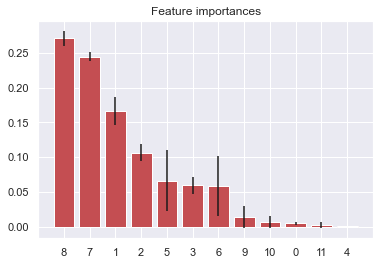

In [175]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print("Feature ranking: ")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance':j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

### <font color = #990775>Feature selection conclusion</font>

**-** From Extra Trees (features that presented more than 5% of importance in the selection above):
* vintage 
* annual_premium 
* age 
* region_code 
* vehicle_damage 
* policy_sales_channel 
* previously_insured

**-** From Boruta:
* age

**-** From EDA:
* age
* gender
* vehicle_damaged
* previously_insured
* vehicle_age

In [68]:
# Mannual selection of the features:

cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = df4[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

Last check for any data types still as object:

In [69]:
x_train.dtypes

annual_premium          float64
vintage                 float64
age                     float64
region_code             float64
vehicle_damage            int64
previously_insured       object
policy_sales_channel    float64
dtype: object

In [70]:
x_train['previously_insured'] = x_train['previously_insured'].astype(int64)

In [71]:
x_val['previously_insured'] = x_val['previously_insured'].astype(int64)

## <font color = #990775>7 - MACHINE LEARNING MODELLING</font>

#### <font color = #990775>K-Neighbours (K-NN)</font>

K-Neighbours
Precision at k=20%: 0.12226959658904558
Recall    at k=20%: 0.1993582887700535
Precision at k=40%: 0.12243760044606251
Recall    at k=40%: 0.3992513368983957


<function __main__.model_performance(model_name, model)>

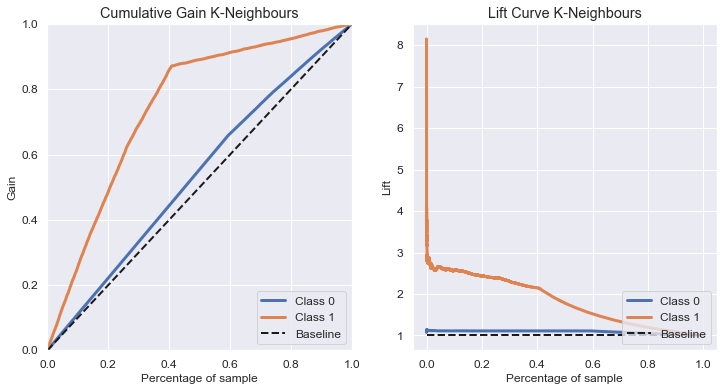

In [74]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training & prediction on validation data
model_performance("K-Neighbours", knn_model)
model_performance

#### <font color = #990775>Logistic Regression</font>

Logistic Regression
Precision at k=20%: 0.1197113807805838
Recall    at k=20%: 0.19518716577540107
Precision at k=40%: 0.12079766473154252
Recall    at k=40%: 0.39390374331550804


<function __main__.model_performance(model_name, model)>

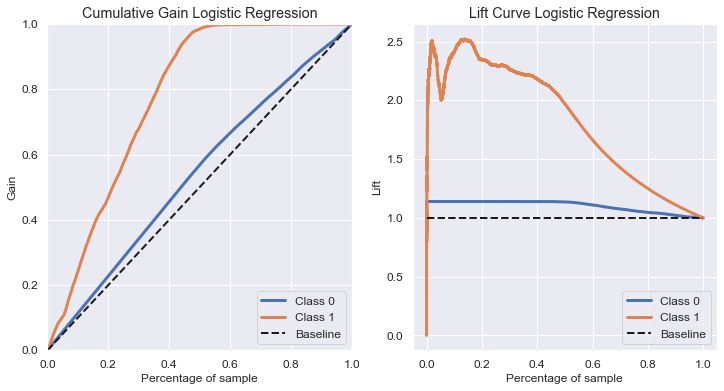

In [75]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training & prediction on validation data
model_performance("Logistic Regression", lr_model)
model_performance

#### <font color = #990775>Extra Trees</font>

Extra Trees
Precision at k=20%: 0.12502459822892753
Recall    at k=20%: 0.20385026737967915
Precision at k=40%: 0.12332316573190331
Recall    at k=40%: 0.4021390374331551


<function __main__.model_performance(model_name, model)>

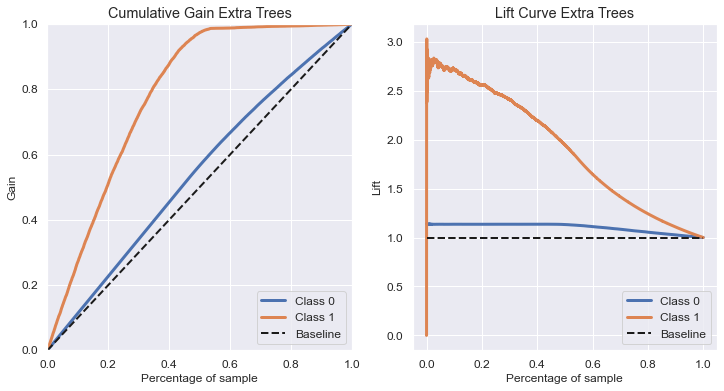

In [76]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=200, random_state=42)

# model training & prediction on validation data
model_performance("Extra Trees", et)
model_performance

#### <font color = #990775>Random Forest</font>

Random Forest
Precision at k=20%: 0.12181042964906527
Recall    at k=20%: 0.1986096256684492
Precision at k=40%: 0.12122404801731772
Recall    at k=40%: 0.3952941176470588


<function __main__.model_performance(model_name, model)>

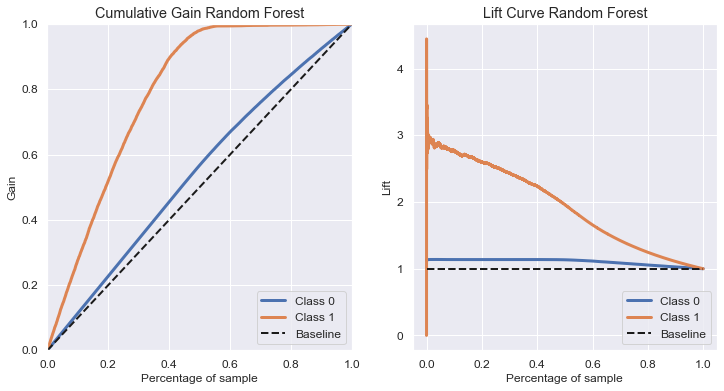

In [77]:
# model definition
rf = en.RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

# model training & prediction on validation data
model_performance("Random Forest", rf)
model_performance

#### <font color = #990775>Light Gradient Boosting Machine (LGBM)</font>

LGBM
Precision at k=20%: 0.11662840275500164
Recall    at k=20%: 0.19016042780748663
Precision at k=40%: 0.11797697530256814
Recall    at k=40%: 0.3847058823529412


<function __main__.model_performance(model_name, model)>

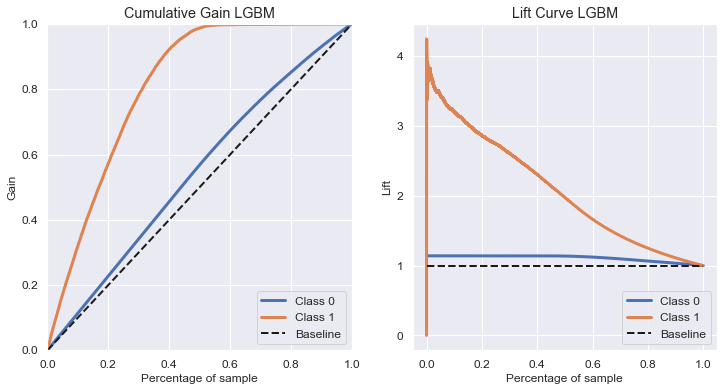

In [78]:
# model definition
lgbm = LGBMClassifier()

# model training & prediction on validation data
model_performance("LGBM", lgbm)
model_performance

#### <font color = #990775>Cross Validation - measuring and comparing the real performance of the models</font>

In [79]:
models_performance = pd.DataFrame({'Model': [], 'Precision_at_k': [], 'Recall_at_k': [], 'F1-Score_at_k': [], 'ROC_AUC_Score': []})

In [80]:
models = {'K-Neighbours Classifier': knn_model, 'Logistic Regression': lr_model, 'Extra Trees': et, 'Random Forest': rf, 'LightGBM': lgbm}

In [81]:
models_performance_cv = cross_validation(models, models_performance, 5, x_val, y_val)
models_performance_cv.sort_values('F1-Score_at_k', ascending=False)

,Model,Precision_at_k,Recall_at_k,F1-Score_at_k,ROC_AUC_Score
0,LightGBM,0.3124 +/- 0.0204,0.5095 +/- 0.0331,0.3872 +/- 0.0252,0.8204 +/- 0.0231
0,Random Forest,0.3038 +/- 0.0124,0.4957 +/- 0.0201,0.3767 +/- 0.0153,0.8128 +/- 0.0195
0,Extra Trees,0.2995 +/- 0.0111,0.4888 +/- 0.0184,0.3714 +/- 0.0138,0.807 +/- 0.0193
0,K-Neighbours Classifier,0.298 +/- 0.0038,0.4862 +/- 0.0064,0.3694 +/- 0.0048,0.7806 +/- 0.0034
0,Logistic Regression,0.2927 +/- 0.0062,0.4775 +/- 0.0101,0.3629 +/- 0.0076,0.7978 +/- 0.0174


## <font color = #990775>8 - HYPERPARAMETERS FINE TUNING</font>

To be applied to the best 3 models sorted by "F1-Score_at_k" in the previous step:

## <font color = #990775>9 - ERROR TRANSLATION AND INTERPRETATION</font>

## <font color = #990775>10 - DEPLOY TO PRODUCTION</font>

(on going)